<a href="https://colab.research.google.com/github/Luke-Williams-01/Luke-Williams-01/blob/main/ICRARproject2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import simps
from scipy import integrate
from scipy import stats, interpolate
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
import pandas as pd

1) Cross-matching the xCOLDGASS sample with the xGASS galaxies to investigate the molecular hydrogen, H2 in the galaxy. This is in the optical region of a galaxy and therefore will not require the process used for HI.

In [2]:
hdulist = fits.open('xGASSCOLD_matched_innHI.fits')
hdu = hdulist[1].data
cols = hdulist[1].columns
# Importing data into arrays
GASS = hdu['GASS']
FLAG_CO = hdu['FLAG_CO']
lgMH2 = hdu['LOGMH2']
limlgMH2 = hdu['LIM_LOGMH2']
lgMH2_2_Ms = hdu['LOGMH2MS']
lgMSTAR = hdu['LOGMSTAR']
SFRbest = hdu['SFR_best']
NUVr = hdu['NUVr_1']
lgMuST = hdu['lgmust']
lgMHI_in = hdu['lgMHI_2Reff']
lgMHI_gl = hdu['lgMHI_global']
B2TM = hdu['B2T_M']
HIsrc = hdu['HIsource']
lgSFRbest = np.log10(SFRbest)
lgsSFR = np.log10((SFRbest) / (10**lgMSTAR))
print('Starting length of the dataset is', len(FLAG_CO))

Starting length of the dataset is 383


In [3]:
# Checking whether any of the galaxies in the dataset are missing important values
print('Data without H2 mass values:', np.where((lgMH2 < 0) & (limlgMH2 < 0))[0], np.where(np.isnan(lgMH2))[0], np.where(np.isnan(limlgMH2))[0])
print('Data without stellar mass values:', np.where(lgMSTAR < 0)[0], np.where(np.isnan(lgMSTAR))[0])
print('Data without NUV-r values:', np.where(NUVr < 0)[0], np.where(np.isnan(NUVr))[0])
print('Data without stellar mass density values:', np.where(lgMuST < 0)[0], np.where(np.isnan(lgMuST))[0])

Data without H2 mass values: [] [] []
Data without stellar mass values: [] []
Data without NUV-r values: [] []
Data without stellar mass density values: [] []


In [4]:
# Need to separate the H2 data into the detections and the non-detection upper limits
# We can use the CO flag for this, 1 = H2 detection, 2 = no H2 detection (upper limit only)
# H2 detections
lgMH2_det = np.delete(lgMH2, (np.where(FLAG_CO > 1)))
lgMSTAR_det = np.delete(lgMSTAR, (np.where(FLAG_CO > 1)))
lgSFRbest_det = np.delete(lgSFRbest, (np.where(FLAG_CO > 1)))
NUVr_det = np.delete(NUVr, (np.where(FLAG_CO > 1)))
lgMuST_det = np.delete(lgMuST, (np.where(FLAG_CO > 1)))
lgsSFR_det = np.delete(lgsSFR, (np.where(FLAG_CO > 1)))
lgMHI_in_det = np.delete(lgMHI_in, (np.where(FLAG_CO > 1)))
lgMHI_gl_det = np.delete(lgMHI_gl, (np.where(FLAG_CO > 1)))
# H2 non-detections
limlgMH2_ndet = np.delete(limlgMH2, (np.where(FLAG_CO < 2)))
lgMSTAR_ndet = np.delete(lgMSTAR, (np.where(FLAG_CO < 2)))
lgSFRbest_ndet = np.delete(lgSFRbest, (np.where(FLAG_CO < 2)))
NUVr_ndet = np.delete(NUVr, (np.where(FLAG_CO < 2)))
lgMuST_ndet = np.delete(lgMuST, (np.where(FLAG_CO < 2)))
lgsSFR_ndet = np.delete(lgsSFR, (np.where(FLAG_CO < 2)))
lgMHI_in_ndet = np.delete(lgMHI_in, (np.where(FLAG_CO < 2)))
lgMHI_gl_ndet = np.delete(lgMHI_gl, (np.where(FLAG_CO < 2)))

2) Plotting how the H2 changes with stellar mass and SFR

In [5]:
# Finding the running median of the galaxies for H2
# Arrays for the bins
H2bins = np.linspace(9, 11.9, 10)
H2bins2 = np.linspace(-1.9, 1.5, 10)

# Array of zeroes to store the median of each bin
mH2_1 = np.zeros(len(H2bins))
H2median1 = np.zeros(len(H2bins))
H2MAD1 = np.zeros(len(H2bins))

mH2_2 = np.zeros(len(H2bins2))
H2median2 = np.zeros(len(H2bins2))
H2MAD2 = np.zeros(len(H2bins2))

# Using a for loop to iterate over the median values for each of the bins
for i in range(len(H2bins) -1):
  # Median and MAD for H2 of galaxies against stellar mass
  H2median1[i] = np.median(lgMH2_det[np.where((lgMSTAR_det >= H2bins[i]) & (lgMSTAR_det <= H2bins[i+1]))])
  H2MAD1[i] = stats.median_abs_deviation(lgMH2_det[np.where((lgMSTAR_det >= H2bins[i]) & (lgMSTAR_det <= H2bins[i+1]))])
  mH2_1[i] = H2median1[i]

  # Median and MAD for H2 of galaxies against SFR
  H2median2[i] = np.median(lgMH2_det[np.where((lgSFRbest_det >= H2bins2[i]) & (lgSFRbest_det <= H2bins2[i+1]))])
  H2MAD2[i] = stats.median_abs_deviation(lgMH2_det[np.where((lgSFRbest_det >= H2bins2[i]) & (lgSFRbest_det <= H2bins2[i+1]))])
  mH2_2[i] = H2median2[i]

# Working out the upper and lower bounds of the median absolute deviation
H2pMAD1 = mH2_1 + H2MAD1
H2nMAD1 = mH2_1 - H2MAD1
H2pMAD2 = mH2_2 + H2MAD2
H2nMAD2 = mH2_2 - H2MAD2

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


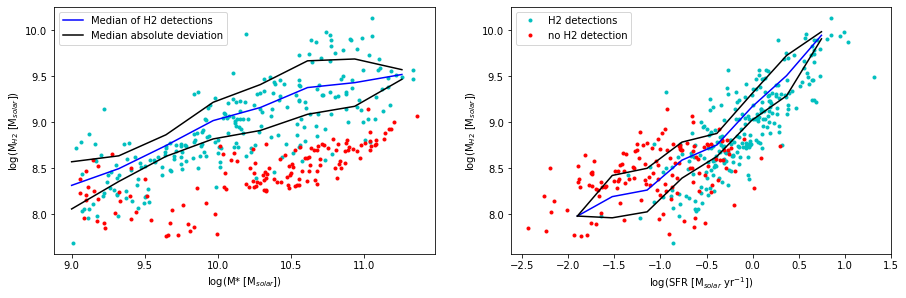

In [6]:
# Plotting the relations between the H2 mass in the galaxy and stellar mass as well as the Star formation rate
plt.figure(figsize = (15,10))
# H2 mass against Stellar mass
plt.subplot(221)
plt.plot(lgMSTAR_det, lgMH2_det, 'c.')
plt.plot(lgMSTAR_ndet, limlgMH2_ndet, 'r.')
plt.plot(H2bins[:-2], mH2_1[:-2], 'b-', label = 'Median of H2 detections')
plt.plot(H2bins[:-2], H2pMAD1[:-2], 'k-', label = 'Median absolute deviation')
plt.plot(H2bins[:-2], H2nMAD1[:-2], 'k-')
plt.xlabel('log(M* [M$_{solar}$])')
plt.ylabel('log(M$_{H2}$ [M$_{solar}$])')
plt.legend(loc='upper left')

# H2 mass against Star formation rate
plt.subplot(222)
plt.plot(lgSFRbest_det, lgMH2_det, 'c.', label= 'H2 detections')
plt.plot(lgSFRbest_ndet, limlgMH2_ndet, 'r.', label= 'no H2 detection')
plt.plot(H2bins2[:-2], mH2_2[:-2], 'b-')
plt.plot(H2bins2[:-2], H2pMAD2[:-2], 'k-')
plt.plot(H2bins2[:-2], H2nMAD2[:-2], 'k-')
plt.xlabel('log(SFR [M$_{solar}$ yr$^{-1}$])')
plt.ylabel('log(M$_{H2}$ [M$_{solar}$])')
plt.legend(loc='upper left');

3) Comparing how the H2 mass changes with various stellar properties, plotted with how the global HI mass changes and how the HI mass inside the optical region changes

In [7]:
# Finding the running median of the galaxies in the sample for the HI global
# Arrays for the bins
HIglbins_Mstar = np.linspace(9, 11.5, 10)
HIglbins_NUVr = np.linspace(1, 5.5, 10)
HIglbins_sSFR = np.linspace(-11.5, -9.5, 10)
HIglbins_Must = np.linspace(7.5, 10, 10)

# Array of zeroes to store the median of each bin
MHIgl_Mstar = np.zeros(len(HIglbins_Mstar))
HIglmedian_Mstar = np.zeros(len(HIglbins_Mstar))
HIglMAD_Mstar = np.zeros(len(HIglbins_Mstar))

MHIgl_NUVr = np.zeros(len(HIglbins_NUVr))
HIglmedian_NUVr = np.zeros(len(HIglbins_NUVr))
HIglMAD_NUVr = np.zeros(len(HIglbins_NUVr))

MHIgl_sSFR = np.zeros(len(HIglbins_sSFR))
HIglmedian_sSFR = np.zeros(len(HIglbins_sSFR))
HIglMAD_sSFR = np.zeros(len(HIglbins_sSFR))

MHIgl_Must = np.zeros(len(HIglbins_Must))
HIglmedian_Must = np.zeros(len(HIglbins_Must))
HIglMAD_Must = np.zeros(len(HIglbins_Must))

In [8]:
# Using a for loop to iterate over the median values for each of the bins
for i in range(len(HIglbins_Mstar) -1):
  # Median and MAD for the Mstar graph
  HIglmedian_Mstar[i] = np.median(lgMHI_gl_det[np.where((lgMSTAR_det >= HIglbins_Mstar[i]) & (lgMSTAR_det <= HIglbins_Mstar[i+1]))])
  HIglMAD_Mstar[i] = stats.median_abs_deviation(lgMHI_gl_det[np.where((lgMSTAR_det >= HIglbins_Mstar[i]) & (lgMSTAR_det <= HIglbins_Mstar[i+1]))])
  MHIgl_Mstar[i] = HIglmedian_Mstar[i]

  # Median and MAD for the NUV-r graph
  HIglmedian_NUVr[i] = np.median(lgMHI_gl_det[np.where((NUVr_det >= HIglbins_NUVr[i]) & (NUVr_det <= HIglbins_NUVr[i+1]))])
  HIglMAD_NUVr[i] = stats.median_abs_deviation(lgMHI_gl_det[np.where((NUVr_det >= HIglbins_NUVr[i]) & (NUVr_det <= HIglbins_NUVr[i+1]))])
  MHIgl_NUVr[i] = HIglmedian_NUVr[i]

  # Median and MAD for the sSFR graph
  HIglmedian_sSFR[i] = np.median(lgMHI_gl_det[np.where((lgsSFR_det >= HIglbins_sSFR[i]) & (lgsSFR_det <= HIglbins_sSFR[i+1]))])
  HIglMAD_sSFR[i] = stats.median_abs_deviation(lgMHI_gl_det[np.where((lgsSFR_det >= HIglbins_sSFR[i]) & (lgsSFR_det <= HIglbins_sSFR[i+1]))])
  MHIgl_sSFR[i] = HIglmedian_sSFR[i]

  #Median and MAD for the Must graph
  HIglmedian_Must[i] = np.median(lgMHI_gl_det[np.where((lgMuST_det >= HIglbins_Must[i]) & (lgMuST_det <= HIglbins_Must[i+1]))])
  HIglMAD_Must[i] = stats.median_abs_deviation(lgMHI_gl_det[np.where((lgMuST_det >= HIglbins_Must[i]) & (lgMuST_det <= HIglbins_Must[i+1]))])
  MHIgl_Must[i] = HIglmedian_Must[i]

# Working out the upper and lower bounds of the median absolute deviation
# Mstar graph median bounds
HIglpMAD_Mstar = MHIgl_Mstar + HIglMAD_Mstar
HIglnMAD_Mstar = MHIgl_Mstar - HIglMAD_Mstar
# NUV-r graph median bounds
HIglpMAD_NUVr = MHIgl_NUVr + HIglMAD_NUVr
HIglnMAD_NUVr = MHIgl_NUVr - HIglMAD_NUVr
# sSFR graph median bounds
HIglpMAD_sSFR = MHIgl_sSFR + HIglMAD_sSFR
HIglnMAD_sSFR = MHIgl_sSFR - HIglMAD_sSFR
# Must graph median bounds
HIglpMAD_Must = MHIgl_Must + HIglMAD_Must
HIglnMAD_Must = MHIgl_Must - HIglMAD_Must

In [9]:
# Finding the running median of the galaxies in the sample for the HI inner
# Arrays for the bins
HIinbins_Mstar = np.linspace(9, 11.5, 10)
HIinbins_NUVr = np.linspace(1, 5.5, 10)
HIinbins_sSFR = np.linspace(-11.5, -9.5, 10)
HIinbins_Must = np.linspace(7.5, 10, 10)

# Array of zeroes to store the median of each bin
MHIin_Mstar = np.zeros(len(HIinbins_Mstar))
HIinmedian_Mstar = np.zeros(len(HIinbins_Mstar))
HIinMAD_Mstar = np.zeros(len(HIinbins_Mstar))

MHIin_NUVr = np.zeros(len(HIinbins_NUVr))
HIinmedian_NUVr = np.zeros(len(HIinbins_NUVr))
HIinMAD_NUVr = np.zeros(len(HIinbins_NUVr))

MHIin_sSFR = np.zeros(len(HIinbins_sSFR))
HIinmedian_sSFR = np.zeros(len(HIinbins_sSFR))
HIinMAD_sSFR = np.zeros(len(HIinbins_sSFR))

MHIin_Must = np.zeros(len(HIinbins_Must))
HIinmedian_Must = np.zeros(len(HIinbins_Must))
HIinMAD_Must = np.zeros(len(HIinbins_Must))

In [10]:
# Using a for loop to iterate over the median values for each of the bins
for i in range(len(HIinbins_Mstar) -1):
  # Median and MAD for the Mstar graph
  HIinmedian_Mstar[i] = np.median(lgMHI_in_det[np.where((lgMSTAR_det >= HIinbins_Mstar[i]) & (lgMSTAR_det <= HIinbins_Mstar[i+1]))])
  HIinMAD_Mstar[i] = stats.median_abs_deviation(lgMHI_in_det[np.where((lgMSTAR_det >= HIinbins_Mstar[i]) & (lgMSTAR_det <= HIinbins_Mstar[i+1]))])
  MHIin_Mstar[i] = HIinmedian_Mstar[i]

  # Median and MAD for the NUV-r graph
  HIinmedian_NUVr[i] = np.median(lgMHI_in_det[np.where((NUVr_det >= HIinbins_NUVr[i]) & (NUVr_det <= HIinbins_NUVr[i+1]))])
  HIinMAD_NUVr[i] = stats.median_abs_deviation(lgMHI_in_det[np.where((NUVr_det >= HIinbins_NUVr[i]) & (NUVr_det <= HIinbins_NUVr[i+1]))])
  MHIin_NUVr[i] = HIinmedian_NUVr[i]

  # Median and MAD for the sSFR graph
  HIinmedian_sSFR[i] = np.median(lgMHI_in_det[np.where((lgsSFR_det >= HIinbins_sSFR[i]) & (lgsSFR_det <= HIinbins_sSFR[i+1]))])
  HIinMAD_sSFR[i] = stats.median_abs_deviation(lgMHI_in_det[np.where((lgsSFR_det >= HIinbins_sSFR[i]) & (lgsSFR_det <= HIinbins_sSFR[i+1]))])
  MHIin_sSFR[i] = HIinmedian_sSFR[i]
  
  #Median and MAD for the Must graph
  HIinmedian_Must[i] = np.median(lgMHI_in_det[np.where((lgMuST_det >= HIinbins_Must[i]) & (lgMuST_det <= HIinbins_Must[i+1]))])
  HIinMAD_Must[i] = stats.median_abs_deviation(lgMHI_in_det[np.where((lgMuST_det >= HIinbins_Must[i]) & (lgMuST_det <= HIinbins_Must[i+1]))])
  MHIin_Must[i] = HIinmedian_Must[i]

# Working out the upper and lower bounds of the median absolute deviation
# Mstar graph median bounds
HIinpMAD_Mstar = MHIin_Mstar + HIinMAD_Mstar
HIinnMAD_Mstar = MHIin_Mstar - HIinMAD_Mstar
# NUV-r graph median bounds
HIinpMAD_NUVr = MHIin_NUVr + HIinMAD_NUVr
HIinnMAD_NUVr = MHIin_NUVr - HIinMAD_NUVr
# sSFR graph median bounds
HIinpMAD_sSFR = MHIin_sSFR + HIinMAD_sSFR
HIinnMAD_sSFR = MHIin_sSFR - HIinMAD_sSFR
# Must graph median bounds
HIinpMAD_Must = MHIin_Must + HIinMAD_Must
HIinnMAD_Must = MHIin_Must - HIinMAD_Must

In [11]:
# Finding the running median for the galaxies in the sample for H2
H2bins_Mstar = np.linspace(9, 11.5, 10)
H2bins_NUVr = np.linspace(1, 5.5, 10)
H2bins_sSFR = np.linspace(-11.5, -9.5, 10)
H2bins_Must = np.linspace(7.5, 10, 10)

# Array of zeroes to store the median of each bin
MH2_Mstar = np.zeros(len(H2bins_Mstar))
H2median_Mstar = np.zeros(len(H2bins_Mstar))
H2MAD_Mstar = np.zeros(len(H2bins_Mstar))

MH2_NUVr = np.zeros(len(H2bins_NUVr))
H2median_NUVr = np.zeros(len(H2bins_NUVr))
H2MAD_NUVr = np.zeros(len(H2bins_NUVr))

MH2_sSFR = np.zeros(len(H2bins_sSFR))
H2median_sSFR = np.zeros(len(H2bins_sSFR))
H2MAD_sSFR = np.zeros(len(H2bins_sSFR))

MH2_Must = np.zeros(len(H2bins_Must))
H2median_Must = np.zeros(len(H2bins_Must))
H2MAD_Must = np.zeros(len(H2bins_Must))

In [12]:
# Using a for loop to iterate over the median values for each of the bins
for i in range(len(H2bins_Mstar) -1):
  # Median and MAD for the Mstar graph
  H2median_Mstar[i] = np.median(lgMH2_det[np.where((lgMSTAR_det >= H2bins_Mstar[i]) & (lgMSTAR_det <= H2bins_Mstar[i+1]))])
  H2MAD_Mstar[i] = stats.median_abs_deviation(lgMH2_det[np.where((lgMSTAR_det >= H2bins_Mstar[i]) & (lgMSTAR_det <= H2bins_Mstar[i+1]))])
  MH2_Mstar[i] = H2median_Mstar[i]

  # Median and MAD for the NUV-r graph
  H2median_NUVr[i] = np.median(lgMH2_det[np.where((NUVr_det >= H2bins_NUVr[i]) & (NUVr_det <= H2bins_NUVr[i+1]))])
  H2MAD_NUVr[i] = stats.median_abs_deviation(lgMH2_det[np.where((NUVr_det >= H2bins_NUVr[i]) & (NUVr_det <= H2bins_NUVr[i+1]))])
  MH2_NUVr[i] = H2median_NUVr[i]

  # Median and MAD for the sSFR graph
  H2median_sSFR[i] = np.median(lgMH2_det[np.where((lgsSFR_det >= H2bins_sSFR[i]) & (lgsSFR_det <= H2bins_sSFR[i+1]))])
  H2MAD_sSFR[i] = stats.median_abs_deviation(lgMH2_det[np.where((lgsSFR_det >= H2bins_sSFR[i]) & (lgsSFR_det <= H2bins_sSFR[i+1]))])
  MH2_sSFR[i] = H2median_sSFR[i]
  
  #Median and MAD for the Must graph
  H2median_Must[i] = np.median(lgMH2_det[np.where((lgMuST_det >= H2bins_Must[i]) & (lgMuST_det <= H2bins_Must[i+1]))])
  H2MAD_Must[i] = stats.median_abs_deviation(lgMH2_det[np.where((lgMuST_det >= H2bins_Must[i]) & (lgMuST_det <= H2bins_Must[i+1]))])
  MH2_Must[i] = H2median_Must[i]

# Working out the upper and lower bounds of the median absolute deviation
# Mstar graph median bounds
H2pMAD_Mstar = MH2_Mstar + H2MAD_Mstar
H2nMAD_Mstar = MH2_Mstar - H2MAD_Mstar
# NUV-r graph median bounds
H2pMAD_NUVr = MH2_NUVr + H2MAD_NUVr
H2nMAD_NUVr = MH2_NUVr - H2MAD_NUVr
# sSFR graph median bounds
H2pMAD_sSFR = MH2_sSFR + H2MAD_sSFR
H2nMAD_sSFR = MH2_sSFR - H2MAD_sSFR
# Must graph median bounds
H2pMAD_Must = MH2_Must + H2MAD_Must
H2nMAD_Must = MH2_Must - H2MAD_Must

In [13]:
# Spearman correlation coefficient for each scatter (detections only)
# For HI (global):
# Mstar
R_HIgl_Mstar = stats.spearmanr(lgMSTAR_det, lgMHI_gl_det)
R_HIgl_Mstarall = stats.spearmanr(lgMSTAR, lgMHI_gl)
# MuStar
R_HIgl_MuST = stats.spearmanr(lgMuST_det, lgMHI_gl_det)
R_HIgl_MuSTall = stats.spearmanr(lgMuST, lgMHI_gl)
# NUVr
R_HIgl_NUVr = stats.spearmanr(NUVr_det, lgMHI_gl_det)
R_HIgl_NUVrall = stats.spearmanr(NUVr, lgMHI_gl)
# sSFR
R_HIgl_sSFR = stats.spearmanr(lgsSFR_det, lgMHI_gl_det)
R_HIgl_sSFRall = stats.spearmanr(lgsSFR, lgMHI_gl)

# For HI (inside)
# Mstar
R_HIin_Mstar = stats.spearmanr(lgMSTAR_det, lgMHI_in_det)
R_HIin_MStarall = stats.spearmanr(lgMSTAR, lgMHI_in)
# MuStar
R_HIin_MuST = stats.spearmanr(lgMuST_det, lgMHI_in_det)
R_HIin_MuSTall = stats.spearmanr(lgMuST, lgMHI_in)
# NUVr
R_HIin_NUVr = stats.spearmanr(NUVr_det, lgMHI_in_det)
R_HIin_NUVrall = stats.spearmanr(NUVr, lgMHI_in)
# sSFR
R_HIin_sSFR = stats.spearmanr(lgsSFR_det, lgMHI_in_det)
R_HIin_sSFRall = stats.spearmanr(lgsSFR, lgMHI_in)

# For H2
# Mstar
R_H2_Mstar = stats.spearmanr(lgMSTAR_det, lgMH2_det)
R_H2_Mstarall = stats.spearmanr(lgMSTAR, lgMH2)
# MuStar
R_H2_MuST = stats.spearmanr(lgMuST_det, lgMH2_det)
R_H2_MuSTall = stats.spearmanr(lgMuST, lgMH2)
# NUVr
R_H2_NUVr = stats.spearmanr(NUVr_det, lgMH2_det)
R_H2_NUVrall = stats.spearmanr(NUVr, lgMH2)
# sSFR
R_H2_sSFR = stats.spearmanr(lgsSFR_det, lgMH2_det)
R_H2_sSFRall = stats.spearmanr(lgsSFR, lgMH2)

In [14]:
print(R_HIgl_Mstarall[0], R_HIgl_MuSTall[0], R_HIgl_NUVrall[0], R_HIgl_sSFRall[0])
print(R_HIin_MStarall[0], R_HIin_MuSTall[0], R_HIin_NUVrall[0], R_HIin_sSFRall[0])
print(R_H2_Mstarall[0], R_H2_MuSTall[0], R_H2_NUVrall[0], R_H2_sSFRall[0])

0.3381952466879446 -0.11805405041160157 -0.4403410199921524 0.3574603958504136
0.5152825710267958 -0.03982984159459204 -0.23365027906766683 0.14898333800390964
0.22604451669666456 -0.13867491897844442 -0.39396848980252547 0.4569920294399481


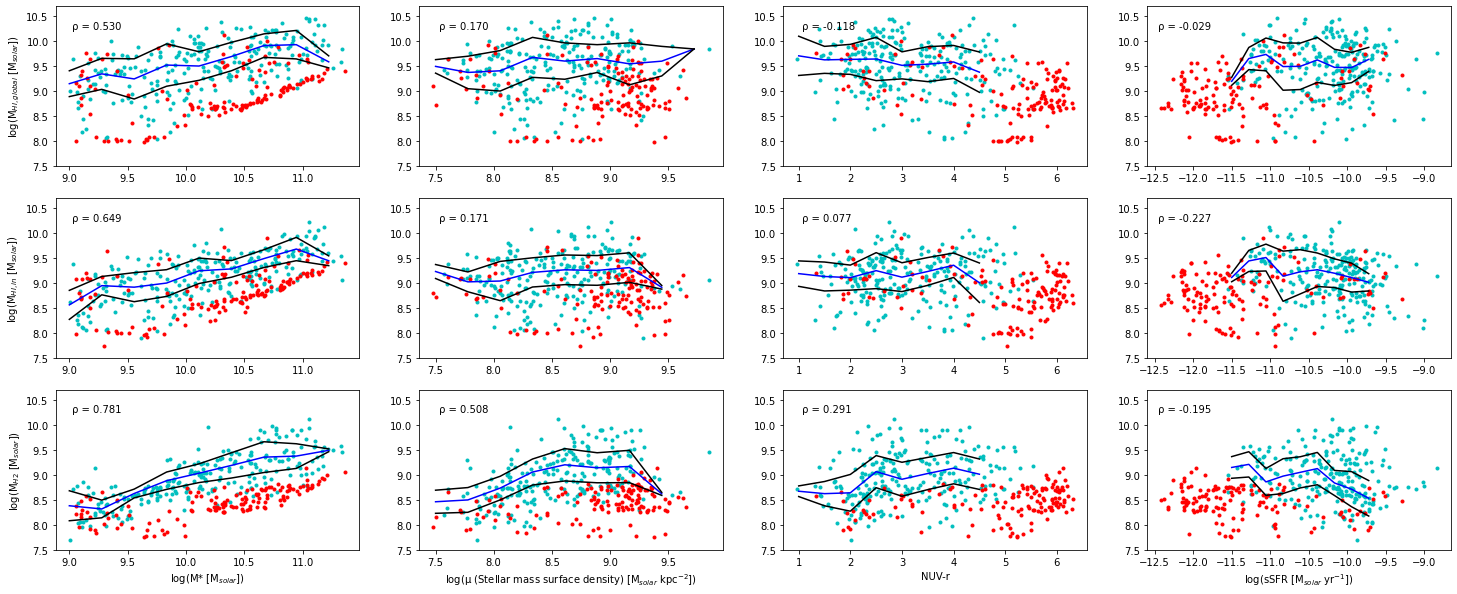

In [15]:
plt.figure(figsize=(25,10))
# Plotting the depletion times for the HI(global) mass against stellar properties
# MHI(global) against stellar mass
plt.subplot(3,4,1)
plt.plot(lgMSTAR_det, lgMHI_gl_det, 'c.')
plt.plot(lgMSTAR_ndet, lgMHI_gl_ndet, 'r.')
plt.plot(HIglbins_Mstar[:-1], MHIgl_Mstar[:-1], 'b-')
plt.plot(HIglbins_Mstar[:-1], HIglpMAD_Mstar[:-1], 'k-')
plt.plot(HIglbins_Mstar[:-1], HIglnMAD_Mstar[:-1], 'k-')
plt.text(9, 10.25, ' ρ = %.3f' % R_HIgl_Mstar[0])
plt.ylabel('log(M$_{HI, global}$ [M$_{solar}$])')
plt.ylim(7.5, 10.7)
# MHI(global) against stellar surface density
plt.subplot(3,4,2)
plt.plot(lgMuST_det, lgMHI_gl_det, 'c.')
plt.plot(lgMuST_ndet, lgMHI_gl_ndet, 'r.')
plt.plot(HIglbins_Must[:-1], MHIgl_Must[:-1], 'b-')
plt.plot(HIglbins_Must[:-1], HIglpMAD_Must[:-1], 'k-')
plt.plot(HIglbins_Must[:-1], HIglnMAD_Must[:-1], 'k-')
plt.text(7.5, 10.25, ' ρ = %.3f' % R_HIgl_MuST[0])
plt.ylim(7.5, 10.7)
# MHI(global) against NUV-r
plt.subplot(3,4,3)
plt.plot(NUVr_det, lgMHI_gl_det, 'c.')
plt.plot(NUVr_ndet, lgMHI_gl_ndet, 'r.')
plt.plot(HIglbins_NUVr[:-2], MHIgl_NUVr[:-2], 'b-')
plt.plot(HIglbins_NUVr[:-2], HIglpMAD_NUVr[:-2], 'k-')
plt.plot(HIglbins_NUVr[:-2], HIglnMAD_NUVr[:-2], 'k-')
plt.text(1, 10.25, ' ρ = %.3f' % R_HIgl_NUVr[0])
plt.ylim(7.5, 10.7)
# MHI(global) against sSFR
plt.subplot(3,4,4)
plt.plot(lgsSFR_det, lgMHI_gl_det, 'c.')
plt.plot(lgsSFR_ndet, lgMHI_gl_ndet, 'r.')
plt.plot(HIglbins_sSFR[:-1], MHIgl_sSFR[:-1], 'b-')
plt.plot(HIglbins_sSFR[:-1], HIglpMAD_sSFR[:-1], 'k-')
plt.plot(HIglbins_sSFR[:-1], HIglnMAD_sSFR[:-1], 'k-')
plt.text(-12.5, 10.25, ' ρ = %.3f' % R_HIgl_sSFR[0])
plt.ylim(7.5, 10.7)

# Plotting the depletion times for the HI(in) mass against stellar properties
# HI(in) against stellar mass
plt.subplot(3,4,5)
plt.plot(lgMSTAR_det, lgMHI_in_det, 'c.')
plt.plot(lgMSTAR_ndet, lgMHI_in_ndet, 'r.')
plt.plot(HIinbins_Mstar[:-1], MHIin_Mstar[:-1], 'b-')
plt.plot(HIinbins_Mstar[:-1], HIinpMAD_Mstar[:-1], 'k-')
plt.plot(HIinbins_Mstar[:-1], HIinnMAD_Mstar[:-1], 'k-')
plt.ylabel('log(M$_{HI, in}$ [M$_{solar}$])')
plt.text(9, 10.25, ' ρ = %.3f' % R_HIin_Mstar[0])
plt.ylim(7.5, 10.7)
# HI(in) against stellar surface density
plt.subplot(3,4,6)
plt.plot(lgMuST_det, lgMHI_in_det, 'c.')
plt.plot(lgMuST_ndet, lgMHI_in_ndet, 'r.')
plt.plot(HIinbins_Must[:-2], MHIin_Must[:-2], 'b-')
plt.plot(HIinbins_Must[:-2], HIinpMAD_Must[:-2], 'k-')
plt.plot(HIinbins_Must[:-2], HIinnMAD_Must[:-2], 'k-')
plt.text(7.5, 10.25, ' ρ = %.3f' % R_HIin_MuST[0])
plt.ylim(7.5, 10.7)
# HI(in) against NUV-r
plt.subplot(3,4,7)
plt.plot(NUVr_det, lgMHI_in_det, 'c.')
plt.plot(NUVr_ndet, lgMHI_in_ndet, 'r.')
plt.plot(HIinbins_NUVr[:-2], MHIin_NUVr[:-2], 'b-')
plt.plot(HIinbins_NUVr[:-2], HIinpMAD_NUVr[:-2], 'k-')
plt.plot(HIinbins_NUVr[:-2], HIinnMAD_NUVr[:-2], 'k-')
plt.text(1, 10.25, ' ρ = %.3f' % R_HIin_NUVr[0])
plt.ylim(7.5, 10.7)
# HI(in) against sSFR
plt.subplot(3,4,8)
plt.plot(lgsSFR_det, lgMHI_in_det, 'c.')
plt.plot(lgsSFR_ndet, lgMHI_in_ndet, 'r.')
plt.plot(HIinbins_sSFR[:-1], MHIin_sSFR[:-1], 'b-')
plt.plot(HIinbins_sSFR[:-1], HIinpMAD_sSFR[:-1], 'k-')
plt.plot(HIinbins_sSFR[:-1], HIinnMAD_sSFR[:-1], 'k-')
plt.text(-12.5, 10.25, ' ρ = %.3f' % R_HIin_sSFR[0])
plt.ylim(7.5, 10.7)

# Plotting the depletion times for the H2 mass against stellar properties
# H2 against stellar mass
plt.subplot(3,4,9)
plt.plot(lgMSTAR_det, lgMH2_det, 'c.')
plt.plot(lgMSTAR_ndet, limlgMH2_ndet, 'r.')
plt.plot(H2bins_Mstar[:-1], MH2_Mstar[:-1], 'b-')
plt.plot(H2bins_Mstar[:-1], H2pMAD_Mstar[:-1], 'k-')
plt.plot(H2bins_Mstar[:-1], H2nMAD_Mstar[:-1], 'k-')
plt.ylabel('log(M$_{H2}$ [M$_{solar}$])')
plt.xlabel('log(M* [M$_{solar}$])')
plt.text(9, 10.25, ' ρ = %.3f' % R_H2_Mstar[0])
plt.ylim(7.5, 10.7)
# H2 against stellar surface density
plt.subplot(3,4,10)
plt.plot(lgMuST_det, lgMH2_det, 'c.')
plt.plot(lgMuST_ndet, limlgMH2_ndet, 'r.')
plt.plot(H2bins_Must[:-2], MH2_Must[:-2], 'b-')
plt.plot(H2bins_Must[:-2], H2pMAD_Must[:-2], 'k-')
plt.plot(H2bins_Must[:-2], H2nMAD_Must[:-2], 'k-')
plt.xlabel('log(μ (Stellar mass surface density) [M$_{solar}$ kpc$^{-2}$])')
plt.text(7.5, 10.25, ' ρ = %.3f' % R_H2_MuST[0])
plt.ylim(7.5, 10.7)
# H2 against NUVr
plt.subplot(3,4,11)
plt.plot(NUVr_det, lgMH2_det, 'c.')
plt.plot(NUVr_ndet, limlgMH2_ndet, 'r.')
plt.plot(H2bins_NUVr[:-2], MH2_NUVr[:-2], 'b-')
plt.plot(H2bins_NUVr[:-2], H2pMAD_NUVr[:-2], 'k-')
plt.plot(H2bins_NUVr[:-2], H2nMAD_NUVr[:-2], 'k-')
plt.xlabel('NUV-r')
plt.text(1, 10.25, ' ρ = %.3f' % R_H2_NUVr[0])
plt.ylim(7.5, 10.7)
# H2 against sSFR
plt.subplot(3,4,12)
plt.plot(lgsSFR_det, lgMH2_det, 'c.')
plt.plot(lgsSFR_ndet, limlgMH2_ndet, 'r.')
plt.plot(H2bins_sSFR[:-1], MH2_sSFR[:-1], 'b-')
plt.plot(H2bins_sSFR[:-1], H2pMAD_sSFR[:-1], 'k-')
plt.plot(H2bins_sSFR[:-1], H2nMAD_sSFR[:-1], 'k-')
plt.xlabel('log(sSFR [M$_{solar}$ yr$^{-1}$])')
plt.text(-12.5, 10.25, ' ρ = %.3f' % R_H2_sSFR[0])
plt.ylim(7.5, 10.7);

In [16]:
# Finding the scatter (difference) between the median lines and the median absolute deviation
# Average scatter of HI (global)
ScatHIgl_Mstar = np.mean(HIglMAD_Mstar)
ScatHIgl_MuST = np.mean(HIglMAD_Must)
ScatHIgl_NUVr = np.mean(HIglMAD_NUVr)
ScatHIgl_sSFR = np.mean(HIglMAD_sSFR)

# Average scatter of HI (inner)
ScatHIin_Mstar = np.mean(HIinMAD_Mstar)
ScatHIin_MuST = np.mean(HIinMAD_Must)
ScatHIin_NUVr = np.mean(HIinMAD_NUVr)
ScatHIin_sSFR = np.mean(HIinMAD_sSFR)

# Average scatter of H2
ScatH2_Mstar = np.mean(H2MAD_Mstar)
ScatH2_MuST = np.mean(H2MAD_Must)
ScatH2_NUVr = np.mean(H2MAD_NUVr)
ScatH2_sSFR = np.mean(H2MAD_sSFR)

4) Investigating how the trends are affected by the binning the bulge-to-total ratio- plotting trends for the spiral dominated galaxies and then for the total of the sample

In [17]:
# Finding the distribution of galaxies in the bulge-to-total sample
print('B/T > 0.6:', len(np.where(B2TM > 0.6)[0]))
print('B/T > 0.4:', len(np.where(B2TM > 0.4)[0]))
print('B/T > 0.2:', len(np.where(B2TM > 0.2)[0]))
print('B/T > 0.1:', len(np.where(B2TM > 0.1)[0]))

B/T > 0.6: 16
B/T > 0.4: 64
B/T > 0.2: 168
B/T > 0.1: 224


In [18]:
# Due to the large number of galaxies dominated by a disk component need to change the bins to focus more of those galaxies
# Over half the galaxies present in the sample are between 0 and 0.2 on the bulge-to-total ratio
lgMH2_tot = lgMH2 + limlgMH2
B2TM1 = B2TM[np.where(B2TM < 0.2)]
B2TM2 = B2TM[np.where((B2TM > 0.2) & (B2TM < 0.4))]
B2TM3 = B2TM[np.where(B2TM > 0.4)]

lgMHI_in1 = lgMHI_in[np.where(B2TM < 0.2)]
lgMHI_in2 = lgMHI_in[np.where((B2TM > 0.2) & (B2TM < 0.4))]
lgMHI_in3 = lgMHI_in[np.where(B2TM > 0.4)]

lgMHI_gl1 = lgMHI_gl[np.where(B2TM < 0.2)]
lgMHI_gl2 = lgMHI_gl[np.where((B2TM > 0.2) & (B2TM < 0.4))]
lgMHI_gl3 = lgMHI_gl[np.where(B2TM > 0.4)]

lgMH2_tot1 = lgMH2_tot[np.where(B2TM < 0.2)]
lgMH2_tot2 = lgMH2_tot[np.where((B2TM > 0.2) & (B2TM < 0.4))]
lgMH2_tot3 = lgMH2_tot[np.where(B2TM > 0.4)]

lgMSTAR1 = lgMSTAR[np.where(B2TM < 0.2)]
lgMSTAR2 = lgMSTAR[np.where((B2TM > 0.2) & (B2TM < 0.4))]
lgMSTAR3 = lgMSTAR[np.where(B2TM > 0.4)]

NUVr1 = NUVr[np.where(B2TM < 0.2)]
NUVr2 = NUVr[np.where((B2TM > 0.2) & (B2TM < 0.4))]
NUVr3 = NUVr[np.where(B2TM > 0.4)]

lgsSFR1 = lgsSFR[np.where(B2TM < 0.2)]
lgsSFR2 = lgsSFR[np.where((B2TM > 0.2) & (B2TM < 0.4))]
lgsSFR3 = lgsSFR[np.where(B2TM > 0.4)]

lgMuST1 = lgMuST[np.where(B2TM < 0.2)]
lgMuST2 = lgMuST[np.where((B2TM > 0.2) & (B2TM < 0.4))]
lgMuST3 = lgMuST[np.where(B2TM > 0.4)]

HIsrc1 = HIsrc[np.where(B2TM < 0.2)]
HIsrc2 = HIsrc[np.where((B2TM > 0.2) & (B2TM < 0.4))]
HIsrc3 = HIsrc[np.where(B2TM > 0.4)]

FLAG_CO1 = FLAG_CO[np.where(B2TM < 0.2)]
FLAG_CO2 = FLAG_CO[np.where((B2TM > 0.2) & (B2TM < 0.4))]
FLAG_CO3 = FLAG_CO[np.where(B2TM > 0.4)]

In [19]:
# Finding which galaxies in each bin are detections vs non-detection
lgMHI_in1_det = lgMHI_in1[np.where(HIsrc1 < 4)]
lgMHI_in1_ndet = lgMHI_in1[np.where(HIsrc1 >= 4)]
lgMHI_in2_det = lgMHI_in2[np.where(HIsrc2 < 4)]
lgMHI_in2_ndet = lgMHI_in2[np.where(HIsrc2 >= 4)]
lgMHI_in3_det = lgMHI_in3[np.where(HIsrc3 < 4)]
lgMHI_in3_ndet = lgMHI_in3[np.where(HIsrc3 >= 4)]

lgMHI_gl1_det = lgMHI_gl1[np.where(HIsrc1 < 4)]
lgMHI_gl1_ndet = lgMHI_gl1[np.where(HIsrc1 >= 4)]
lgMHI_gl2_det = lgMHI_gl2[np.where(HIsrc2 < 4)]
lgMHI_gl2_ndet = lgMHI_gl2[np.where(HIsrc2 >= 4)]
lgMHI_gl3_det = lgMHI_gl3[np.where(HIsrc3 < 4)]
lgMHI_gl3_ndet = lgMHI_gl3[np.where(HIsrc3 >= 4)]

lgMH2_tot1_det = lgMH2_tot1[np.where(FLAG_CO1 < 2)]
lgMH2_tot1_ndet = lgMH2_tot1[np.where(FLAG_CO1 > 1)]
lgMH2_tot2_det = lgMH2_tot2[np.where(FLAG_CO2 < 2)]
lgMH2_tot2_ndet = lgMH2_tot2[np.where(FLAG_CO2 > 1)]
lgMH2_tot3_det = lgMH2_tot3[np.where(FLAG_CO3 < 2)]
lgMH2_tot3_ndet = lgMH2_tot3[np.where(FLAG_CO3 > 1)]

In [20]:
# Adjusting the x-axis (stellar properties arrays) so that the detections and non-detections are of the same length
lgMSTAR1_det = lgMSTAR1[np.where(HIsrc1 < 4)]
lgMSTAR1_ndet = lgMSTAR1[np.where(HIsrc1 >= 4)]
lgMSTAR2_det = lgMSTAR2[np.where(HIsrc2 < 4)]
lgMSTAR2_ndet = lgMSTAR2[np.where(HIsrc2 >= 4)]
lgMSTAR3_det = lgMSTAR3[np.where(HIsrc3 < 4)]
lgMSTAR3_ndet = lgMSTAR3[np.where(HIsrc3 >= 4)]

NUVr1_det = NUVr1[np.where(HIsrc1 < 4)]
NUVr1_ndet = NUVr1[np.where(HIsrc1 >= 4)]
NUVr2_det = NUVr2[np.where(HIsrc2 < 4)]
NUVr2_ndet = NUVr2[np.where(HIsrc2 >= 4)]
NUVr3_det = NUVr3[np.where(HIsrc3 < 4)]
NUVr3_ndet = NUVr3[np.where(HIsrc3 >= 4)]

lgsSFR1_det = lgsSFR1[np.where(HIsrc1 < 4)]
lgsSFR1_ndet = lgsSFR1[np.where(HIsrc1 >= 4)]
lgsSFR2_det = lgsSFR2[np.where(HIsrc2 < 4)]
lgsSFR2_ndet = lgsSFR2[np.where(HIsrc2 >= 4)]
lgsSFR3_det = lgsSFR3[np.where(HIsrc3 < 4)]
lgsSFR3_ndet = lgsSFR3[np.where(HIsrc3 >= 4)]

lgMuST1_det = lgMuST1[np.where(HIsrc1 < 4)]
lgMuST1_ndet = lgMuST1[np.where(HIsrc1 >= 4)]
lgMuST2_det = lgMuST2[np.where(HIsrc2 < 4)]
lgMuST2_ndet = lgMuST2[np.where(HIsrc2 >= 4)]
lgMuST3_det = lgMuST3[np.where(HIsrc3 < 4)]
lgMuST3_ndet = lgMuST3[np.where(HIsrc3 >= 4)]

In [21]:
# x-axis values for the H2 where the detections and non-detections of CO are different to those of HI
lgMSTAR1_detH2 = lgMSTAR1[np.where(FLAG_CO1 < 2)]
lgMSTAR1_ndetH2 = lgMSTAR1[np.where(FLAG_CO1 > 1)]
lgMSTAR2_detH2 = lgMSTAR2[np.where(FLAG_CO2 < 2)]
lgMSTAR2_ndetH2 = lgMSTAR2[np.where(FLAG_CO2 > 1)]
lgMSTAR3_detH2 = lgMSTAR3[np.where(FLAG_CO3 < 2)]
lgMSTAR3_ndetH2 = lgMSTAR3[np.where(FLAG_CO3 > 1)]

NUVr1_detH2 = NUVr1[np.where(FLAG_CO1 < 2)]
NUVr1_ndetH2 = NUVr1[np.where(FLAG_CO1 > 1)]
NUVr2_detH2 = NUVr2[np.where(FLAG_CO2 < 2)]
NUVr2_ndetH2 = NUVr2[np.where(FLAG_CO2 > 1)]
NUVr3_detH2 = NUVr3[np.where(FLAG_CO3 < 2)]
NUVr3_ndetH2 = NUVr3[np.where(FLAG_CO3 > 1)]

lgsSFR1_detH2 = lgsSFR1[np.where(FLAG_CO1 < 2)]
lgsSFR1_ndetH2 = lgsSFR1[np.where(FLAG_CO1 > 1)]
lgsSFR2_detH2 = lgsSFR2[np.where(FLAG_CO2 < 2)]
lgsSFR2_ndetH2 = lgsSFR2[np.where(FLAG_CO2 > 1)]
lgsSFR3_detH2 = lgsSFR3[np.where(FLAG_CO3 < 2)]
lgsSFR3_ndetH2 = lgsSFR3[np.where(FLAG_CO3 > 1)]

lgMuST1_detH2 = lgMuST1[np.where(FLAG_CO1 < 2)]
lgMuST1_ndetH2 = lgMuST1[np.where(FLAG_CO1 > 1)]
lgMuST2_detH2 = lgMuST2[np.where(FLAG_CO2 < 2)]
lgMuST2_ndetH2 = lgMuST2[np.where(FLAG_CO2 > 1)]
lgMuST3_detH2 = lgMuST3[np.where(FLAG_CO3 < 2)]
lgMuST3_ndetH2 = lgMuST3[np.where(FLAG_CO3 > 1)]

In [22]:
# Finding the running median of the galaxies in the sample for the HI global (B2TM < 0.2)
# Arrays for the bins
bins_Mstar = np.linspace(9, 11.5, 10)
bins_NUVr = np.linspace(1, 7, 10)
bins_sSFR = np.linspace(-11.5, -9.0, 10)
bins_Must = np.linspace(7.5, 10, 10)

In [23]:
# Finding the running median of the galaxies in the sample for the HI (global)
# Array of zeroes to store the median of each bin
HIglmedian_Mstar = np.zeros(len(bins_Mstar)) 
HIglmedian_Mstar1 = np.zeros(len(bins_Mstar)) # <--- if the variable has 1 at the end it is for B2TM < 0.2

HIglmedian_NUVr = np.zeros(len(bins_NUVr))
HIglmedian_NUVr1 = np.zeros(len(bins_NUVr))

HIglmedian_sSFR = np.zeros(len(bins_sSFR))
HIglmedian_sSFR1 = np.zeros(len(bins_sSFR))

HIglmedian_Must = np.zeros(len(bins_Must))
HIglmedian_Must1 = np.zeros(len(bins_Must))

In [24]:
# Using a for loop to iterate over the median values for each of the bins
for i in range(len(bins_Mstar) -1):
  # Medians for the Mstar graph
  HIglmedian_Mstar[i] = np.median(lgMHI_gl[np.where((lgMSTAR[np.where(lgMHI_gl)] >= bins_Mstar[i]) & (lgMSTAR[np.where(lgMHI_gl)] <= bins_Mstar[i+1]))])
  HIglmedian_Mstar1[i] = np.median(lgMHI_gl1[np.where((lgMSTAR1[np.where(lgMHI_gl1)] >= bins_Mstar[i]) & (lgMSTAR1[np.where(lgMHI_gl1)] <= bins_Mstar[i+1]))])

  # Medians for the NUVr graph
  HIglmedian_NUVr[i] = np.median(lgMHI_gl[np.where((NUVr[np.where(lgMHI_gl)] >= bins_NUVr[i]) & (NUVr[np.where(lgMHI_gl)] <= bins_NUVr[i+1]))])
  HIglmedian_NUVr1[i] = np.median(lgMHI_gl1[np.where((NUVr1[np.where(lgMHI_gl1)] >= bins_NUVr[i]) & (NUVr1[np.where(lgMHI_gl1)] <= bins_NUVr[i+1]))])

  # Medians for the sSFR graph
  HIglmedian_sSFR[i] = np.median(lgMHI_gl[np.where((lgsSFR[np.where(lgMHI_gl)] >= bins_sSFR[i]) & (lgsSFR[np.where(lgMHI_gl)] <= bins_sSFR[i+1]))])
  HIglmedian_sSFR1[i] = np.median(lgMHI_gl1[np.where((lgsSFR1[np.where(lgMHI_gl1)] >= bins_sSFR[i]) & (lgsSFR1[np.where(lgMHI_gl1)] <= bins_sSFR[i+1]))])
  
  # Medians for the Mu star graph
  HIglmedian_Must[i] = np.median(lgMHI_gl[np.where((lgMuST[np.where(lgMHI_gl)] >= bins_Must[i]) & (lgMuST[np.where(lgMHI_gl)] <= bins_Must[i+1]))])
  HIglmedian_Must1[i] = np.median(lgMHI_gl1[np.where((lgMuST1[np.where(lgMHI_gl1)] >= bins_Must[i]) & (lgMuST1[np.where(lgMHI_gl1)] <= bins_Must[i+1]))]) 

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [25]:
# Finding the running median of the galaxies in the sample for the HI (inner)
# Array of zeroes to store the median of each bin
HIinmedian_Mstar = np.zeros(len(bins_Mstar)) 
HIinmedian_Mstar1 = np.zeros(len(bins_Mstar)) # <--- if the variable has 1 at the end it is for B2TM < 0.2

HIinmedian_NUVr = np.zeros(len(bins_NUVr))
HIinmedian_NUVr1 = np.zeros(len(bins_NUVr))

HIinmedian_sSFR = np.zeros(len(bins_sSFR))
HIinmedian_sSFR1 = np.zeros(len(bins_sSFR))

HIinmedian_Must = np.zeros(len(bins_Must))
HIinmedian_Must1 = np.zeros(len(bins_Must))

In [26]:
# Using a for loop to iterate over the median values for each of the bins
for i in range(len(bins_Mstar) -1):
  # Medians for the Mstar graph
  HIinmedian_Mstar[i] = np.median(lgMHI_in[np.where((lgMSTAR[np.where(lgMHI_in)] >= bins_Mstar[i]) & (lgMSTAR[np.where(lgMHI_in)] <= bins_Mstar[i+1]))])
  HIinmedian_Mstar1[i] = np.median(lgMHI_in1[np.where((lgMSTAR1[np.where(lgMHI_in1)] >= bins_Mstar[i]) & (lgMSTAR1[np.where(lgMHI_in1)] <= bins_Mstar[i+1]))])

  # Medians for the NUVr graph
  HIinmedian_NUVr[i] = np.median(lgMHI_in[np.where((NUVr[np.where(lgMHI_in)] >= bins_NUVr[i]) & (NUVr[np.where(lgMHI_in)] <= bins_NUVr[i+1]))])
  HIinmedian_NUVr1[i] = np.median(lgMHI_in1[np.where((NUVr1[np.where(lgMHI_in1)] >= bins_NUVr[i]) & (NUVr1[np.where(lgMHI_in1)] <= bins_NUVr[i+1]))])

  # Medians for the sSFR graph
  HIinmedian_sSFR[i] = np.median(lgMHI_in[np.where((lgsSFR[np.where(lgMHI_in)] >= bins_sSFR[i]) & (lgsSFR[np.where(lgMHI_in)] <= bins_sSFR[i+1]))])
  HIinmedian_sSFR1[i] = np.median(lgMHI_in1[np.where((lgsSFR1[np.where(lgMHI_in1)] >= bins_sSFR[i]) & (lgsSFR1[np.where(lgMHI_in1)] <= bins_sSFR[i+1]))])
  
  # Medians for the Mu star graph
  HIinmedian_Must[i] = np.median(lgMHI_in[np.where((lgMuST[np.where(lgMHI_in)] >= bins_Must[i]) & (lgMuST[np.where(lgMHI_in)] <= bins_Must[i+1]))])
  HIinmedian_Must1[i] = np.median(lgMHI_in1[np.where((lgMuST1[np.where(lgMHI_in1)] >= bins_Must[i]) & (lgMuST1[np.where(lgMHI_in1)] <= bins_Must[i+1]))]) 

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [27]:
# Finding the running median of the galaxies in the sample for the H2
# Array of zeroes to store the median of each bin
H2median_Mstar = np.zeros(len(bins_Mstar)) 
H2median_Mstar1 = np.zeros(len(bins_Mstar)) # <--- if the variable has 1 at the end it is for B2TM < 0.2

H2median_NUVr = np.zeros(len(bins_NUVr))
H2median_NUVr1 = np.zeros(len(bins_NUVr))

H2median_sSFR = np.zeros(len(bins_sSFR))
H2median_sSFR1 = np.zeros(len(bins_sSFR))

H2median_Must = np.zeros(len(bins_Must))
H2median_Must1 = np.zeros(len(bins_Must))

In [28]:
# Using a for loop to iterate over the median values for each of the bins
for i in range(len(bins_Mstar) -1):
  # Medians for the Mstar graph
  H2median_Mstar[i] = np.median(lgMH2_tot[np.where((lgMSTAR[np.where(lgMH2_tot)] >= bins_Mstar[i]) & (lgMSTAR[np.where(lgMH2_tot)] <= bins_Mstar[i+1]))])
  H2median_Mstar1[i] = np.median(lgMH2_tot1[np.where((lgMSTAR1[np.where(lgMH2_tot1)] >= bins_Mstar[i]) & (lgMSTAR1[np.where(lgMH2_tot1)] <= bins_Mstar[i+1]))])

  # Medians for the NUVr graph
  H2median_NUVr[i] = np.median(lgMH2_tot[np.where((NUVr[np.where(lgMH2_tot)] >= bins_NUVr[i]) & (NUVr[np.where(lgMH2_tot)] <= bins_NUVr[i+1]))])
  H2median_NUVr1[i] = np.median(lgMH2_tot1[np.where((NUVr1[np.where(lgMH2_tot1)] >= bins_NUVr[i]) & (NUVr1[np.where(lgMH2_tot1)] <= bins_NUVr[i+1]))])

  # Medians for the sSFR graph
  H2median_sSFR[i] = np.median(lgMH2_tot[np.where((lgsSFR[np.where(lgMH2_tot)] >= bins_sSFR[i]) & (lgsSFR[np.where(lgMH2_tot)] <= bins_sSFR[i+1]))])
  H2median_sSFR1[i] = np.median(lgMH2_tot1[np.where((lgsSFR1[np.where(lgMH2_tot1)] >= bins_sSFR[i]) & (lgsSFR1[np.where(lgMH2_tot1)] <= bins_sSFR[i+1]))])

  # Medians for the Mu star graph
  H2median_Must[i] = np.median(lgMH2_tot[np.where((lgMuST[np.where(lgMH2_tot)] >= bins_Must[i]) & (lgMuST[np.where(lgMH2_tot)] <= bins_Must[i+1]))])
  H2median_Must1[i] = np.median(lgMH2_tot1[np.where((lgMuST1[np.where(lgMH2_tot1)] >= bins_Must[i]) & (lgMuST1[np.where(lgMH2_tot1)] <= bins_Must[i+1]))]) 

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


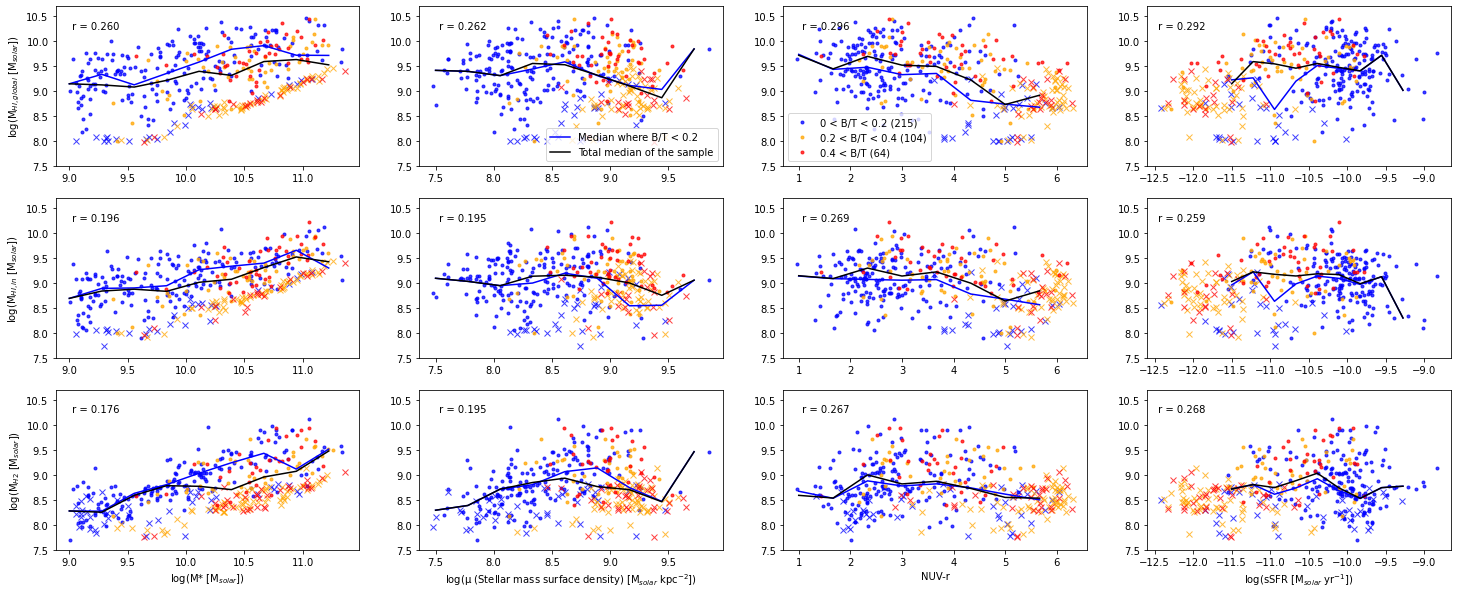

In [29]:
plt.figure(figsize=(25,10))
# Plotting the HI(global) mass against stellar properties
# MHI(global) against stellar mass
plt.subplot(3,4,1)
plt.plot(lgMSTAR1_det, lgMHI_gl1_det, 'blue', alpha = 0.75, marker='.', linestyle='none')
plt.plot(lgMSTAR1_ndet, lgMHI_gl1_ndet, 'blue', alpha = 0.75, marker='x', linestyle='none')
plt.plot(lgMSTAR2_det, lgMHI_gl2_det, 'orange', alpha = 0.75, marker='.', linestyle='none')
plt.plot(lgMSTAR2_ndet, lgMHI_gl2_ndet, 'orange', alpha = 0.75, marker='x', linestyle='none')
plt.plot(lgMSTAR3_det, lgMHI_gl3_det, 'red', alpha = 0.75, marker='.', linestyle='none')
plt.plot(lgMSTAR3_ndet, lgMHI_gl3_ndet, 'red', alpha = 0.75, marker='x', linestyle='none')
plt.plot(bins_Mstar[:-1], HIglmedian_Mstar1[:-1], 'b-')
plt.plot(bins_Mstar[:-1], HIglmedian_Mstar[:-1], 'k-')
plt.ylabel('log(M$_{HI, global}$ [M$_{solar}$])')
plt.text(9, 10.25, ' r = %.3f' % ScatHIgl_Mstar)
plt.ylim(7.5, 10.7)
# MHI(global) against stellar surface density
plt.subplot(3,4,2)
plt.plot(lgMuST1_det, lgMHI_gl1_det, 'blue', alpha = 0.75, marker = '.', linestyle='none')
plt.plot(lgMuST1_ndet, lgMHI_gl1_ndet, 'blue', alpha = 0.75, marker = 'x', linestyle='none')
plt.plot(lgMuST2_det, lgMHI_gl2_det, 'orange', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgMuST2_ndet, lgMHI_gl2_ndet, 'orange', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(lgMuST3_det, lgMHI_gl3_det, 'red', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgMuST3_ndet, lgMHI_gl3_ndet, 'red', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(bins_Must[:-1], HIglmedian_Must1[:-1], 'b-', label='Median where B/T < 0.2')
plt.plot(bins_Must[:-1], HIglmedian_Must[:-1], 'k-', label='Total median of the sample')
plt.legend(loc='lower right')
plt.text(7.5, 10.25, ' r = %.3f' % ScatHIgl_MuST)
plt.ylim(7.5, 10.7)
# MHI(global) against NUV-r
plt.subplot(3,4,3)
plt.plot(NUVr1_det, lgMHI_gl1_det,'blue', alpha = 0.75, marker= '.', linestyle='none', label='0 < B/T < 0.2 (215)')
plt.plot(NUVr1_ndet, lgMHI_gl1_ndet,'blue', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(NUVr2_det, lgMHI_gl2_det, 'orange', alpha = 0.75, marker= '.', linestyle='none', label='0.2 < B/T < 0.4 (104)')
plt.plot(NUVr2_ndet, lgMHI_gl2_ndet, 'orange', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(NUVr3_det, lgMHI_gl3_det, 'red', alpha = 0.75, marker= '.', linestyle='none', label='0.4 < B/T (64)')
plt.plot(NUVr3_ndet, lgMHI_gl3_ndet, 'red', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(bins_NUVr[:-1], HIglmedian_NUVr1[:-1], 'b-')
plt.plot(bins_NUVr[:-1], HIglmedian_NUVr[:-1], 'k-')
plt.text(1, 10.25, ' r = %.3f' % ScatHIgl_NUVr)
plt.legend(loc='lower left')
plt.ylim(7.5, 10.7)
# MHI(global) against sSFR
plt.subplot(3,4,4)
plt.plot(lgsSFR1_det, lgMHI_gl1_det, 'blue', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgsSFR1_ndet, lgMHI_gl1_ndet, 'blue', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(lgsSFR2_det, lgMHI_gl2_det, 'orange', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgsSFR2_ndet, lgMHI_gl2_ndet, 'orange', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(lgsSFR3_det, lgMHI_gl3_det, 'red', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgsSFR3_ndet, lgMHI_gl3_ndet, 'red', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(bins_sSFR[:-1], HIglmedian_sSFR1[:-1], 'b-')
plt.plot(bins_sSFR[:-1], HIglmedian_sSFR[:-1], 'k-')
plt.text(-12.5, 10.25, ' r = %.3f' % ScatHIgl_sSFR)
plt.ylim(7.5, 10.7)

# Plotting the HI(in) mass against stellar properties
# HI(in) against stellar mass
plt.subplot(3,4,5)
plt.plot(lgMSTAR1_det, lgMHI_in1_det, 'blue', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgMSTAR1_ndet, lgMHI_in1_ndet, 'blue', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(lgMSTAR2_det, lgMHI_in2_det, 'orange', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgMSTAR2_ndet, lgMHI_in2_ndet, 'orange', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(lgMSTAR3_det, lgMHI_in3_det, 'red', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgMSTAR3_ndet, lgMHI_in3_ndet, 'red', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(bins_Mstar[:-1], HIinmedian_Mstar1[:-1], 'b-')
plt.plot(bins_Mstar[:-1], HIinmedian_Mstar[:-1], 'k-')
plt.ylabel('log(M$_{HI, in}$ [M$_{solar}$])')
plt.text(9, 10.25, ' r = %.3f' % ScatHIin_Mstar)
plt.ylim(7.5, 10.7)
# HI(in) against stellar surface density
plt.subplot(3,4,6)
plt.plot(lgMuST1_det, lgMHI_in1_det, 'blue', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgMuST1_ndet, lgMHI_in1_ndet, 'blue', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(lgMuST2_det, lgMHI_in2_det, 'orange', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgMuST2_ndet, lgMHI_in2_ndet, 'orange', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(lgMuST3_det, lgMHI_in3_det, 'red', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgMuST3_ndet, lgMHI_in3_ndet, 'red', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(bins_Must[:-1], HIinmedian_Must1[:-1], 'b-')
plt.plot(bins_Must[:-1], HIinmedian_Must[:-1], 'k-')
plt.text(7.5, 10.25, ' r = %.3f' % ScatHIin_MuST)
plt.ylim(7.5, 10.7)
# HI(in) against NUV-r
plt.subplot(3,4,7)
plt.plot(NUVr1_det, lgMHI_in1_det, 'blue', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(NUVr1_ndet, lgMHI_in1_ndet, 'blue', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(NUVr2_det, lgMHI_in2_det, 'orange', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(NUVr2_ndet, lgMHI_in2_ndet, 'orange', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(NUVr3_det, lgMHI_in3_det, 'red', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(NUVr3_ndet, lgMHI_in3_ndet, 'red', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(bins_NUVr[:-1], HIinmedian_NUVr1[:-1], 'b-')
plt.plot(bins_NUVr[:-1], HIinmedian_NUVr[:-1], 'k-')
plt.text(1, 10.25, ' r = %.3f' % ScatHIin_NUVr)
plt.ylim(7.5, 10.7)
# HI(in) against sSFR
plt.subplot(3,4,8)
plt.plot(lgsSFR1_det, lgMHI_in1_det, 'blue', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgsSFR1_ndet, lgMHI_in1_ndet, 'blue', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(lgsSFR2_det, lgMHI_in2_det, 'orange', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgsSFR2_ndet, lgMHI_in2_ndet, 'orange', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(lgsSFR3_det, lgMHI_in3_det, 'red', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgsSFR3_ndet, lgMHI_in3_ndet, 'red', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(bins_sSFR[:-1], HIinmedian_sSFR1[:-1], 'b-')
plt.plot(bins_sSFR[:-1], HIinmedian_sSFR[:-1], 'k-')
plt.text(-12.5, 10.25, ' r = %.3f' % ScatHIin_sSFR)
plt.ylim(7.5, 10.7)

# Plotting the the H2 mass against stellar properties
# H2 against stellar mass
plt.subplot(3,4,9)
plt.plot(lgMSTAR1_detH2, lgMH2_tot1_det, 'blue', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgMSTAR1_ndetH2, lgMH2_tot1_ndet, 'blue', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(lgMSTAR2_detH2, lgMH2_tot2_det, 'orange', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgMSTAR2_ndetH2, lgMH2_tot2_ndet, 'orange', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(lgMSTAR3_detH2, lgMH2_tot3_det, 'red', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgMSTAR3_ndetH2, lgMH2_tot3_ndet, 'red', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(bins_Mstar[:-1], H2median_Mstar1[:-1], 'b-')
plt.plot(bins_Mstar[:-1], H2median_Mstar[:-1], 'k-')
plt.ylabel('log(M$_{H2}$ [M$_{solar}$])')
plt.xlabel('log(M* [M$_{solar}$])')
plt.text(9, 10.25, ' r = %.3f' % ScatH2_Mstar)
plt.ylim(7.5, 10.7)
# H2 against stellar surface density
plt.subplot(3,4,10)
plt.plot(lgMuST1_detH2, lgMH2_tot1_det, 'blue', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgMuST1_ndetH2, lgMH2_tot1_ndet, 'blue', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(lgMuST2_detH2, lgMH2_tot2_det, 'orange', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgMuST2_ndetH2, lgMH2_tot2_ndet, 'orange', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(lgMuST3_detH2, lgMH2_tot3_det, 'red', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgMuST3_ndetH2, lgMH2_tot3_ndet, 'red', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(bins_Must[:-1], H2median_Must1[:-1], 'b-')
plt.plot(bins_Must[:-1], H2median_Must[:-1], 'k-')
plt.xlabel('log(μ (Stellar mass surface density) [M$_{solar}$ kpc$^{-2}$])')
plt.text(7.5, 10.25, ' r = %.3f' % ScatH2_MuST)
plt.ylim(7.5, 10.7)
# H2 against NUVr
plt.subplot(3,4,11)
plt.plot(NUVr1_detH2, lgMH2_tot1_det, 'blue', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(NUVr1_ndetH2, lgMH2_tot1_ndet, 'blue', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(NUVr2_detH2, lgMH2_tot2_det, 'orange', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(NUVr2_ndetH2, lgMH2_tot2_ndet, 'orange', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(NUVr3_detH2, lgMH2_tot3_det, 'red', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(NUVr3_ndetH2, lgMH2_tot3_ndet, 'red', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(bins_NUVr[:-1], H2median_NUVr1[:-1], 'b-')
plt.plot(bins_NUVr[:-1], H2median_NUVr[:-1], 'k-')
plt.text(1, 10.25, ' r = %.3f' % ScatH2_NUVr)
plt.xlabel('NUV-r')
plt.ylim(7.5, 10.7)
# H2 against sSFR
plt.subplot(3,4,12)
plt.plot(lgsSFR1_detH2, lgMH2_tot1_det, 'blue', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgsSFR1_ndetH2, lgMH2_tot1_ndet, 'blue', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(lgsSFR2_detH2, lgMH2_tot2_det, 'orange', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgsSFR2_ndetH2, lgMH2_tot2_ndet, 'orange', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(lgsSFR3_detH2, lgMH2_tot3_det, 'red', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgsSFR3_ndetH2, lgMH2_tot3_ndet, 'red', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(bins_sSFR[:-1], H2median_sSFR1[:-1], 'b-')
plt.plot(bins_sSFR[:-1], H2median_sSFR[:-1], 'k-')
plt.xlabel('log(sSFR [M$_{solar}$ yr$^{-1}$])')
plt.text(-12.5, 10.25, ' r = %.3f' % ScatH2_sSFR)
plt.ylim(7.5, 10.7);

5) Comparison of how the mass of HI (global) and the mass of HI (interior) compare with the mass of the H2

In [30]:
# We have four cases of detections vs non-detections:
# (1) HI flag is 1,2,3- a detection AND CO flag is 1- a detection
# (2) HI flag is 4- a non-detection AND CO flag is 2- a non-detection
# (3) HI flag is 1,2,3- detection AND CO flag is 2- a non detection
# (4) HI flag is 4- a non-detection AND CO flag is 1- a detection
# For the scaling relations of MH2/MHI(in) and MH2/MHI(global):
# Case (1) are galaxies detections
# Case (2) are galaxy non-detections and must be removed from the sample
# Case (3) are upper limits
# Case (4) are the lower limits

# Finding the amount of galaxies that fit each criteria, each will be suffixed by a 1,2,3,4 based on the definitions above:
# HI (global) mass
lgMHI_gl_det1 = lgMHI_gl[np.where((HIsrc < 4) & (FLAG_CO < 2))]
lgMHI_gl_det2 = lgMHI_gl[np.where((HIsrc >= 4) & (FLAG_CO > 1))]
lgMHI_gl_det3 = lgMHI_gl[np.where((HIsrc < 4) & (FLAG_CO > 1))]
lgMHI_gl_det4 = lgMHI_gl[np.where((HIsrc >= 4) & (FLAG_CO < 2))]
# HI (inner) mass
lgMHI_in_det1 = lgMHI_in[np.where((HIsrc < 4) & (FLAG_CO < 2))]
lgMHI_in_det2 = lgMHI_in[np.where((HIsrc >= 4) & (FLAG_CO > 1))]
lgMHI_in_det3 = lgMHI_in[np.where((HIsrc < 4) & (FLAG_CO > 1))]
lgMHI_in_det4 = lgMHI_in[np.where((HIsrc >= 4) & (FLAG_CO < 2))]
# H2 mass
lgMH2_det1 = lgMH2_tot[np.where((HIsrc < 4) & (FLAG_CO < 2))]
lgMH2_det2 = lgMH2_tot[np.where((HIsrc >= 4) & (FLAG_CO > 1))]
lgMH2_det3 = lgMH2_tot[np.where((HIsrc < 4) & (FLAG_CO > 1))]
lgMH2_det4 = lgMH2_tot[np.where((HIsrc >= 4) & (FLAG_CO < 2))]
# Stellar mass
lgMSTAR_det1 = lgMSTAR[np.where((HIsrc < 4) & (FLAG_CO < 2))]
lgMSTAR_det2 = lgMSTAR[np.where((HIsrc >= 4) & (FLAG_CO > 1))]
lgMSTAR_det3 = lgMSTAR[np.where((HIsrc < 4) & (FLAG_CO > 1))]
lgMSTAR_det4 = lgMSTAR[np.where((HIsrc >= 4) & (FLAG_CO < 2))]
# Stellar mass surface density
lgMuST_det1 = lgMuST[np.where((HIsrc < 4) & (FLAG_CO < 2))]
lgMuST_det2 = lgMuST[np.where((HIsrc >= 4) & (FLAG_CO > 1))]
lgMuST_det3 = lgMuST[np.where((HIsrc < 4) & (FLAG_CO > 1))]
lgMuST_det4 = lgMuST[np.where((HIsrc >= 4) & (FLAG_CO < 2))]
# NUVr
NUVr_det1 = NUVr[np.where((HIsrc < 4) & (FLAG_CO < 2))]
NUVr_det2 = NUVr[np.where((HIsrc >= 4) & (FLAG_CO > 1))]
NUVr_det3 = NUVr[np.where((HIsrc < 4) & (FLAG_CO > 1))]
NUVr_det4 = NUVr[np.where((HIsrc >= 4) & (FLAG_CO < 2))]
# sSFR
lgsSFR_det1 = lgsSFR[np.where((HIsrc < 4) & (FLAG_CO < 2))]
lgsSFR_det2 = lgsSFR[np.where((HIsrc >= 4) & (FLAG_CO > 1))]
lgsSFR_det3 = lgsSFR[np.where((HIsrc < 4) & (FLAG_CO > 1))]
lgsSFR_det4 = lgsSFR[np.where((HIsrc >= 4) & (FLAG_CO < 2))]
# B2TM
B2TM_det1 = B2TM[np.where((HIsrc < 4) & (FLAG_CO < 2))]
B2TM_det2 = B2TM[np.where((HIsrc >= 4) & (FLAG_CO > 1))]
B2TM_det3 = B2TM[np.where((HIsrc < 4) & (FLAG_CO > 1))]
B2TM_det4 = B2TM[np.where((HIsrc >= 4) & (FLAG_CO < 2))]
# SFR
lgSFRbest_det1 = lgSFRbest[np.where((HIsrc < 4) & (FLAG_CO < 2))]
lgSFRbest_det2 = lgSFRbest[np.where((HIsrc >= 4) & (FLAG_CO > 1))]
lgSFRbest_det3 = lgSFRbest[np.where((HIsrc < 4) & (FLAG_CO > 1))]
lgSFRbest_det4 = lgSFRbest[np.where((HIsrc >= 4) & (FLAG_CO < 2))]

In [31]:
# We can now compute the mass fractions, ignoring any variable with a '2' suffix
# H2/HI(global)
H2HIgl_det1 = np.log10((10**lgMH2_det1) / (10**lgMHI_gl_det1))
H2HIgl_det3 = np.log10((10**lgMH2_det3) / (10**lgMHI_gl_det3))
H2HIgl_det4 = np.log10((10**lgMH2_det4) / (10**lgMHI_gl_det4))
# H2/HI(inner)
H2HIin_det1 = np.log10((10**lgMH2_det1) / (10**lgMHI_in_det1))
H2HIin_det3 = np.log10((10**lgMH2_det3) / (10**lgMHI_in_det3))
H2HIin_det4 = np.log10((10**lgMH2_det4) / (10**lgMHI_in_det4))

In [32]:
# Finding the running median of the galaxies in the sample for the H2/HI(global)
# Arrays for the bins
bins_Mstar = np.linspace(9.25, 11, 10)
bins_NUVr = np.linspace(1.5, 7.5, 10)
bins_sSFR = np.linspace(-11.15, -9.25, 10)
bins_Must = np.linspace(7.75, 9.4, 10)

# Array of zeroes to store the median of each bin
H2HIgl_median_Mstar = np.zeros(len(bins_Mstar)) 
H2HIgl_MAD_Mstar = np.zeros(len(bins_Mstar))

H2HIgl_median_NUVr = np.zeros(len(bins_NUVr))
H2HIgl_MAD_NUVr = np.zeros(len(bins_NUVr))

H2HIgl_median_sSFR = np.zeros(len(bins_sSFR))
H2HIgl_MAD_sSFR = np.zeros(len(bins_sSFR))

H2HIgl_median_Must = np.zeros(len(bins_Must))
H2HIgl_MAD_Must = np.zeros(len(bins_Must))

In [33]:
# Finding the running median of the galaxies in the sample for the H2/HI(inner)
# Arrays for the zeros to store the median of each bin
H2HIin_median_Mstar = np.zeros(len(bins_Mstar)) 
H2HIin_MAD_Mstar = np.zeros(len(bins_Mstar))

H2HIin_median_NUVr = np.zeros(len(bins_NUVr))
H2HIin_MAD_NUVr = np.zeros(len(bins_NUVr))

H2HIin_median_sSFR = np.zeros(len(bins_sSFR))
H2HIin_MAD_sSFR = np.zeros(len(bins_sSFR))

H2HIin_median_Must = np.zeros(len(bins_Must))
H2HIin_MAD_Must = np.zeros(len(bins_Must))

In [34]:
# Using a for loop to iterate over the median values for each of the bins
for i in range(len(bins_Mstar) -1):
  # H2/HI (global)
  # Median and MAD for the Mstar graph
  H2HIgl_median_Mstar[i] = np.median(H2HIgl_det1[np.where((lgMSTAR_det1 >= bins_Mstar[i]) & (lgMSTAR_det1 <= bins_Mstar[i+1]))])
  H2HIgl_MAD_Mstar[i] = stats.median_abs_deviation(H2HIgl_det1[np.where((lgMSTAR_det1 >= bins_Mstar[i]) & (lgMSTAR_det1 <= bins_Mstar[i+1]))])

  # Median and MAD for the NUV-r graph
  H2HIgl_median_NUVr[i] = np.median(H2HIgl_det1[np.where((NUVr_det1 >= bins_NUVr[i]) & (NUVr_det1 <= bins_NUVr[i+1]))])
  H2HIgl_MAD_NUVr[i] = stats.median_abs_deviation(H2HIgl_det1[np.where((NUVr_det1 >= bins_NUVr[i]) & (NUVr_det1 <= bins_NUVr[i+1]))])

  # Median and MAD for the sSFR graph
  H2HIgl_median_sSFR[i] = np.median(H2HIgl_det1[np.where((lgsSFR_det1 >= bins_sSFR[i]) & (lgsSFR_det1 <= bins_sSFR[i+1]))])
  H2HIgl_MAD_sSFR[i] = stats.median_abs_deviation(H2HIgl_det1[np.where((lgsSFR_det1 >= bins_sSFR[i]) & (lgsSFR_det1 <= bins_sSFR[i+1]))])
  
  #Median and MAD for the Must graph
  H2HIgl_median_Must[i] = np.median(H2HIgl_det1[np.where((lgMuST_det1 >= bins_Must[i]) & (lgMuST_det1 <= bins_Must[i+1]))])
  H2HIgl_MAD_Must[i] = stats.median_abs_deviation(H2HIgl_det1[np.where((lgMuST_det1 >= bins_Must[i]) & (lgMuST_det1 <= bins_Must[i+1]))])

  # H2/HI (optical)
  # Median and MAD for the Mstar graph
  H2HIin_median_Mstar[i] = np.median(H2HIin_det1[np.where((lgMSTAR_det1 >= bins_Mstar[i]) & (lgMSTAR_det1 <= bins_Mstar[i+1]))])
  H2HIin_MAD_Mstar[i] = stats.median_abs_deviation(H2HIin_det1[np.where((lgMSTAR_det1 >= bins_Mstar[i]) & (lgMSTAR_det1 <= bins_Mstar[i+1]))])

  # Median and MAD for the NUV-r graph
  H2HIin_median_NUVr[i] = np.median(H2HIin_det1[np.where((NUVr_det1 >= bins_NUVr[i]) & (NUVr_det1 <= bins_NUVr[i+1]))])
  H2HIin_MAD_NUVr[i] = stats.median_abs_deviation(H2HIin_det1[np.where((NUVr_det1 >= bins_NUVr[i]) & (NUVr_det1 <= bins_NUVr[i+1]))])

  # Median and MAD for the sSFR graph
  H2HIin_median_sSFR[i] = np.median(H2HIin_det1[np.where((lgsSFR_det1 >= bins_sSFR[i]) & (lgsSFR_det1 <= bins_sSFR[i+1]))])
  H2HIin_MAD_sSFR[i] = stats.median_abs_deviation(H2HIin_det1[np.where((lgsSFR_det1 >= bins_sSFR[i]) & (lgsSFR_det1 <= bins_sSFR[i+1]))])
  
  #Median and MAD for the Must graph
  H2HIin_median_Must[i] = np.median(H2HIin_det1[np.where((lgMuST_det1 >= bins_Must[i]) & (lgMuST_det1 <= bins_Must[i+1]))])
  H2HIin_MAD_Must[i] = stats.median_abs_deviation(H2HIin_det1[np.where((lgMuST_det1 >= bins_Must[i]) & (lgMuST_det1 <= bins_Must[i+1]))])

# Working out the upper and lower bounds of the median absolute deviation
# H2/HI (global)
# Mstar graph median bounds
H2HIgl_pMAD_Mstar = H2HIgl_median_Mstar + H2HIgl_MAD_Mstar
H2HIgl_nMAD_Mstar = H2HIgl_median_Mstar - H2HIgl_MAD_Mstar
# NUV-r graph median bounds
H2HIgl_pMAD_NUVr = H2HIgl_median_NUVr + H2HIgl_MAD_NUVr
H2HIgl_nMAD_NUVr = H2HIgl_median_NUVr - H2HIgl_MAD_NUVr
# sSFR graph median bounds
H2HIgl_pMAD_sSFR = H2HIgl_median_sSFR + H2HIgl_MAD_sSFR
H2HIgl_nMAD_sSFR = H2HIgl_median_sSFR - H2HIgl_MAD_sSFR
# Must graph median bounds
H2HIgl_pMAD_Must = H2HIgl_median_Must + H2HIgl_MAD_Must
H2HIgl_nMAD_Must = H2HIgl_median_Must - H2HIgl_MAD_Must

# H2/HI (optical)
# Mstar graph median bounds
H2HIin_pMAD_Mstar = H2HIin_median_Mstar + H2HIin_MAD_Mstar
H2HIin_nMAD_Mstar = H2HIin_median_Mstar - H2HIin_MAD_Mstar
# NUV-r graph median bounds
H2HIin_pMAD_NUVr = H2HIin_median_NUVr + H2HIin_MAD_NUVr
H2HIin_nMAD_NUVr = H2HIin_median_NUVr - H2HIin_MAD_NUVr
# sSFR graph median bounds
H2HIin_pMAD_sSFR = H2HIin_median_sSFR + H2HIin_MAD_sSFR
H2HIin_nMAD_sSFR = H2HIin_median_sSFR - H2HIin_MAD_sSFR
# Must graph median bounds
H2HIin_pMAD_Must = H2HIin_median_Must + H2HIin_MAD_Must
H2HIin_nMAD_Must = H2HIin_median_Must - H2HIin_MAD_Must

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [35]:
# Finding the average scatter of the detections on each plot, mean of the MAD values for each plot:
# H2/HI (global)
ScatH2HIgl_Mstar = np.mean(H2HIgl_MAD_Mstar[:-1])
ScatH2HIgl_NUVr = np.mean(H2HIgl_MAD_NUVr[:-4])
ScatH2HIgl_sSFR = np.mean(H2HIgl_MAD_sSFR[:-2])
ScatH2HIgl_Must = np.mean(H2HIgl_MAD_Must[:-1])
# H2/HI (optical)
ScatH2HIin_Mstar = np.mean(H2HIin_MAD_Mstar[:-1])
ScatH2HIin_NUVr = np.mean(H2HIin_MAD_NUVr[:-4])
ScatH2HIin_sSFR = np.mean(H2HIin_MAD_sSFR[:-2])
ScatH2HIin_Must = np.mean(H2HIin_MAD_Must[:-1])

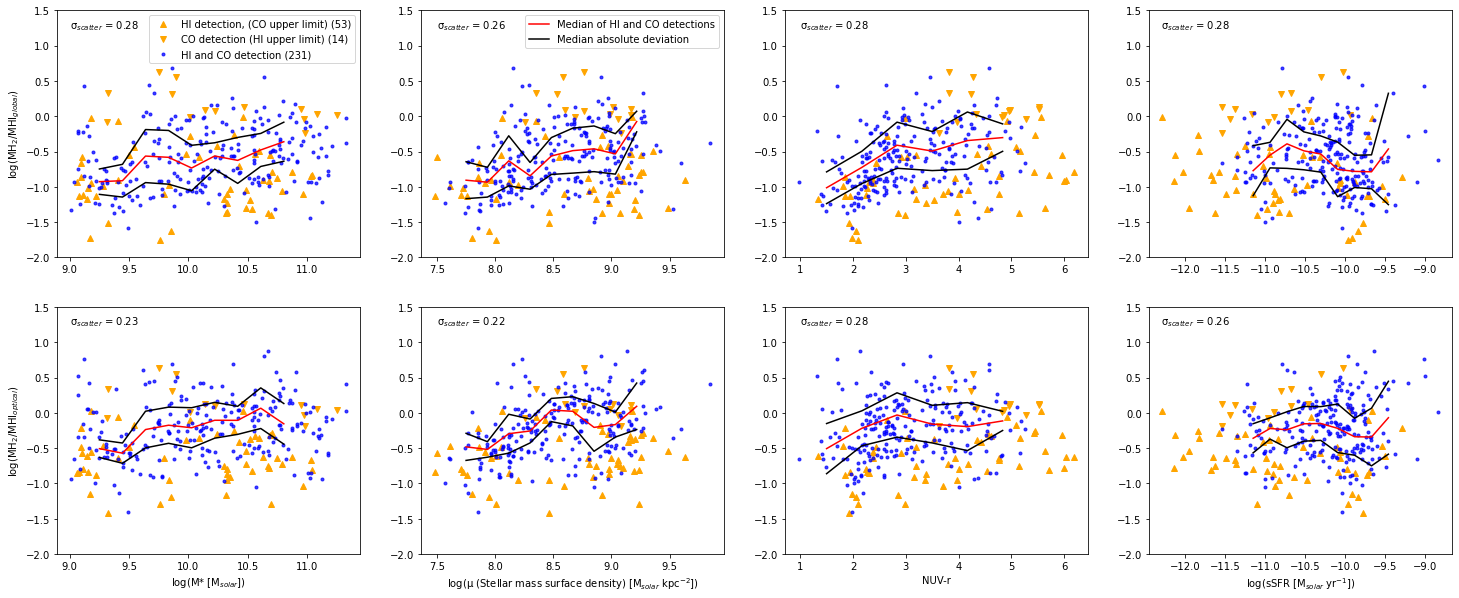

In [36]:
# Plotting the mass fractions against the four stellar properties seen before
plt.figure(figsize=(25,10))
# H2/HI(global) stellar mass
plt.subplot(2,4,1)
plt.plot(lgMSTAR_det3, H2HIgl_det3, 'orange', marker = '^', linestyle='none', label='HI detection, (CO upper limit) (53)')
plt.plot(lgMSTAR_det4, H2HIgl_det4, 'orange', marker = 'v', linestyle='none', label='CO detection (HI upper limit) (14)')
plt.plot(lgMSTAR_det1, H2HIgl_det1, 'blue', marker = '.', linestyle ='none', alpha = 0.75, label='HI and CO detection (231)')
plt.ylabel('log(MH$_{2}$/MHI$_{global}$)')
plt.plot(bins_Mstar[:-1], H2HIgl_median_Mstar[:-1], 'r-')
plt.plot(bins_Mstar[:-1], H2HIgl_pMAD_Mstar[:-1], 'k-')
plt.plot(bins_Mstar[:-1], H2HIgl_nMAD_Mstar[:-1], 'k-')
plt.ylim(-2, 1.5)
plt.legend(loc='upper right')
plt.text(9, 1.25, 'σ$_{scatter}$ = %.2f' % ScatH2HIgl_Mstar)
# H2/HI(global) stellar surface density
plt.subplot(2,4,2)
plt.plot(lgMuST_det3, H2HIgl_det3, 'orange', marker = '^', linestyle='none')
plt.plot(lgMuST_det4, H2HIgl_det4, 'orange', marker = 'v', linestyle='none')
plt.plot(lgMuST_det1, H2HIgl_det1, 'blue', marker = '.', linestyle='none', alpha = 0.75)
plt.plot(bins_Must[:-1], H2HIgl_median_Must[:-1], 'r-', label='Median of HI and CO detections')
plt.plot(bins_Must[:-1], H2HIgl_pMAD_Must[:-1], 'k-', label='Median absolute deviation')
plt.plot(bins_Must[:-1], H2HIgl_nMAD_Must[:-1], 'k-')
plt.ylim(-2, 1.5)
plt.legend(loc='upper right')
plt.text(7.5, 1.25, 'σ$_{scatter}$ = %.2f' % ScatH2HIgl_Must)
# H2/HI(global) NUVr
plt.subplot(2,4,3)
plt.plot(NUVr_det3, H2HIgl_det3, 'orange', marker = '^', linestyle='none')
plt.plot(NUVr_det4, H2HIgl_det4, 'orange', marker = 'v', linestyle='none')
plt.plot(NUVr_det1, H2HIgl_det1, 'blue', marker = '.', linestyle='none', alpha = 0.75)
plt.plot(bins_NUVr[:-1], H2HIgl_median_NUVr[:-1], 'r-')
plt.plot(bins_NUVr[:-1], H2HIgl_pMAD_NUVr[:-1], 'k-')
plt.plot(bins_NUVr[:-1], H2HIgl_nMAD_NUVr[:-1], 'k-')
plt.ylim(-2, 1.5)
plt.text(1, 1.25, 'σ$_{scatter}$ = %.2f' % ScatH2HIgl_NUVr)
# H2/HI(global) sSFR
plt.subplot(2,4,4)
plt.plot(lgsSFR_det3, H2HIgl_det3, 'orange', marker = '^', linestyle='none')
plt.plot(lgsSFR_det4, H2HIgl_det4, 'orange', marker = 'v', linestyle='none')
plt.plot(lgsSFR_det1, H2HIgl_det1, 'blue', marker = '.', linestyle='none', alpha = 0.75)
plt.plot(bins_sSFR[:-1], H2HIgl_median_sSFR[:-1], 'r-')
plt.plot(bins_sSFR[:-1], H2HIgl_pMAD_sSFR[:-1], 'k-')
plt.plot(bins_sSFR[:-1], H2HIgl_nMAD_sSFR[:-1], 'k-')
plt.ylim(-2, 1.5)
plt.text(-12.3, 1.25, 'σ$_{scatter}$ = %.2f' % ScatH2HIgl_sSFR)

# H2/HI(inner) stellar mass
plt.subplot(2,4,5)
plt.plot(lgMSTAR_det3, H2HIin_det3, 'orange', marker = '^', linestyle='none')
plt.plot(lgMSTAR_det4, H2HIin_det4, 'orange', marker = 'v', linestyle='none')
plt.plot(lgMSTAR_det1, H2HIin_det1, 'blue', marker = '.', linestyle='none', alpha = 0.75)
plt.ylabel('log(MH$_{2}$/MHI$_{optical}$)')
plt.xlabel('log(M* [M$_{solar}$])')
plt.plot(bins_Mstar[:-1], H2HIin_median_Mstar[:-1], 'r-')
plt.plot(bins_Mstar[:-1], H2HIin_pMAD_Mstar[:-1], 'k-')
plt.plot(bins_Mstar[:-1], H2HIin_nMAD_Mstar[:-1], 'k-')
plt.ylim(-2, 1.5)
plt.text(9, 1.25, 'σ$_{scatter}$ = %.2f' % ScatH2HIin_Mstar)
# H2/HI(inner) stellar surface density
plt.subplot(2,4,6)
plt.plot(lgMuST_det3, H2HIin_det3, 'orange', marker = '^', linestyle='none')
plt.plot(lgMuST_det4, H2HIin_det4, 'orange', marker = 'v', linestyle='none')
plt.plot(lgMuST_det1, H2HIin_det1, 'blue', marker = '.', linestyle='none', alpha = 0.75)
plt.xlabel('log(μ (Stellar mass surface density) [M$_{solar}$ kpc$^{-2}$])')
plt.plot(bins_Must[:-1], H2HIin_median_Must[:-1], 'r-')
plt.plot(bins_Must[:-1], H2HIin_pMAD_Must[:-1], 'k-')
plt.plot(bins_Must[:-1], H2HIin_nMAD_Must[:-1], 'k-')
plt.ylim(-2, 1.5)
plt.text(7.5, 1.25, 'σ$_{scatter}$ = %.2f' % ScatH2HIin_Must)
# H2/HI(inner) NUVr
plt.subplot(2,4,7)
plt.plot(NUVr_det3, H2HIin_det3, 'orange', marker = '^', linestyle='none')
plt.plot(NUVr_det4, H2HIin_det4, 'orange', marker = 'v', linestyle='none')
plt.plot(NUVr_det1, H2HIin_det1, 'blue', marker = '.', linestyle='none', alpha = 0.75)
plt.xlabel('NUV-r')
plt.plot(bins_NUVr[:-1], H2HIin_median_NUVr[:-1], 'r-')
plt.plot(bins_NUVr[:-1], H2HIin_pMAD_NUVr[:-1], 'k-')
plt.plot(bins_NUVr[:-1], H2HIin_nMAD_NUVr[:-1], 'k-')
plt.ylim(-2, 1.5)
plt.text(1, 1.25, 'σ$_{scatter}$ = %.2f' % ScatH2HIin_NUVr)
# H2/HI(inner) sSFR
plt.subplot(2,4,8)
plt.plot(lgsSFR_det3, H2HIin_det3, 'orange', marker = '^', linestyle='none')
plt.plot(lgsSFR_det4, H2HIin_det4, 'orange', marker = 'v', linestyle='none')
plt.plot(lgsSFR_det1, H2HIin_det1, 'blue', marker = '.', linestyle='none', alpha = 0.75)
plt.xlabel('log(sSFR [M$_{solar}$ yr$^{-1}$])')
plt.plot(bins_sSFR[:-1], H2HIin_median_sSFR[:-1], 'r-')
plt.plot(bins_sSFR[:-1], H2HIin_pMAD_sSFR[:-1], 'k-')
plt.plot(bins_sSFR[:-1], H2HIin_nMAD_sSFR[:-1], 'k-')
plt.ylim(-2, 1.5)
plt.text(-12.3, 1.25, 'σ$_{scatter}$ = %.2f' % ScatH2HIin_sSFR);

6) Looking at the depletion time for the gases

In [37]:
# Depletion times are given by t(dep) = M(gas)/SFR
# Depletion time for HI (global, detections)
lgtdep_HIgl_det1 = np.log10((10**lgMHI_gl_det1) / ((10**lgsSFR_det1) * (10**lgMSTAR_det1)))
# Depletion time for HI (global, upper and lower limits)
lgtdep_HIgl_det3 = np.log10((10**lgMHI_gl_det3) / ((10**lgsSFR_det3) * (10**lgMSTAR_det3)))
lgtdep_HIgl_det4 = np.log10((10**lgMHI_gl_det4) / ((10**lgsSFR_det4) * (10**lgMSTAR_det4)))

# Depletion time for HI (optical, detections)
lgtdep_HIin_det1 = np.log10((10**lgMHI_in_det1) / ((10**lgsSFR_det1) * (10**lgMSTAR_det1)))
# Depletion time for HI (optical, upper and lower limits)
lgtdep_HIin_det3 = np.log10((10**lgMHI_in_det3) / ((10**lgsSFR_det3) * (10**lgMSTAR_det3)))
lgtdep_HIin_det4 = np.log10((10**lgMHI_in_det4) / ((10**lgsSFR_det4) * (10**lgMSTAR_det4)))

# Depletion time for H2 (detections)
lgtdep_H2_det1 = np.log10((10**lgMH2_det1) / ((10**lgsSFR_det1) * (10**lgMSTAR_det1)))
# Depletion time for H2 (upper and lower limits)
lgtdep_H2_det3 = np.log10((10**lgMH2_det3) / ((10**lgsSFR_det3) * (10**lgMSTAR_det3)))
lgtdep_H2_det4 = np.log10((10**lgMH2_det4) / ((10**lgsSFR_det4) * (10**lgMSTAR_det4)))

In [38]:
# Finding the running median of the galaxies in the sample for the HI global
# Arrays for the bins
bins_Mstar = np.linspace(9, 11.25, 10)
bins_NUVr = np.linspace(1, 5.5, 10)
bins_sSFR = np.linspace(-11.25, -9.5, 10)
bins_Must = np.linspace(7.5, 9.5, 10)

In [39]:
# Array of zeroes to store the median of each bin
# Depletion times for HI (global)
tdep_HIglmedian_Mstar = np.zeros(len(bins_Mstar))
tdep_HIglMAD_Mstar = np.zeros(len(bins_Mstar))

tdep_HIglmedian_NUVr = np.zeros(len(bins_NUVr))
tdep_HIglMAD_NUVr = np.zeros(len(bins_NUVr))

tdep_HIglmedian_sSFR = np.zeros(len(bins_sSFR))
tdep_HIglMAD_sSFR = np.zeros(len(bins_sSFR))

tdep_HIglmedian_Must = np.zeros(len(bins_Must))
tdep_HIglMAD_Must = np.zeros(len(bins_Must))

# Depletion times for HI (optical)
tdep_HIinmedian_Mstar = np.zeros(len(bins_Mstar))
tdep_HIinMAD_Mstar = np.zeros(len(bins_Mstar))

tdep_HIinmedian_NUVr = np.zeros(len(bins_NUVr))
tdep_HIinMAD_NUVr = np.zeros(len(bins_NUVr))

tdep_HIinmedian_sSFR = np.zeros(len(bins_sSFR))
tdep_HIinMAD_sSFR = np.zeros(len(bins_sSFR))

tdep_HIinmedian_Must = np.zeros(len(bins_Must))
tdep_HIinMAD_Must = np.zeros(len(bins_Must))

# Depletion time for H2
tdep_H2median_Mstar = np.zeros(len(bins_Mstar))
tdep_H2MAD_Mstar = np.zeros(len(H2bins_Mstar))

tdep_H2median_NUVr = np.zeros(len(bins_NUVr))
tdep_H2MAD_NUVr = np.zeros(len(bins_NUVr))

tdep_H2median_sSFR = np.zeros(len(bins_sSFR))
tdep_H2MAD_sSFR = np.zeros(len(bins_sSFR))

tdep_H2median_Must = np.zeros(len(bins_Must))
tdep_H2MAD_Must = np.zeros(len(bins_Must))

In [40]:
# Using a for loop to iterate over the median values for each of the bins
for i in range(len(bins_Mstar) -1):
  # Depletion time of HI (global)
  # Median and MAD for the Mstar graph
  tdep_HIglmedian_Mstar[i] = np.median(lgtdep_HIgl_det1[np.where((lgMSTAR_det1 >= bins_Mstar[i]) & (lgMSTAR_det1 <= bins_Mstar[i+1]))])
  tdep_HIglMAD_Mstar[i] = stats.median_abs_deviation(lgtdep_HIgl_det1[np.where((lgMSTAR_det1 >= bins_Mstar[i]) & (lgMSTAR_det1 <= bins_Mstar[i+1]))])

  # Median and MAD for the NUV-r graph
  tdep_HIglmedian_NUVr[i] = np.median(lgtdep_HIgl_det1[np.where((NUVr_det1 >= bins_NUVr[i]) & (NUVr_det1 <= bins_NUVr[i+1]))])
  tdep_HIglMAD_NUVr[i] = stats.median_abs_deviation(lgtdep_HIgl_det1[np.where((NUVr_det1 >= bins_NUVr[i]) & (NUVr_det1 <= bins_NUVr[i+1]))])

  # Median and MAD for the sSFR graph
  tdep_HIglmedian_sSFR[i] = np.median(lgtdep_HIgl_det1[np.where((lgsSFR_det1 >= bins_sSFR[i]) & (lgsSFR_det1 <= bins_sSFR[i+1]))])
  tdep_HIglMAD_sSFR[i] = stats.median_abs_deviation(lgtdep_HIgl_det1[np.where((lgsSFR_det1 >= bins_sSFR[i]) & (lgsSFR_det1 <= bins_sSFR[i+1]))])

  # Median and MAD for the Must graph
  tdep_HIglmedian_Must[i] = np.median(lgtdep_HIgl_det1[np.where((lgMuST_det1 >= bins_Must[i]) & (lgMuST_det1 <= bins_Must[i+1]))])
  tdep_HIglMAD_Must[i] = stats.median_abs_deviation(lgtdep_HIgl_det1[np.where((lgMuST_det1 >= bins_Must[i]) & (lgMuST_det1 <= bins_Must[i+1]))])

  # Depletion time of HI (optical)
  # Median and MAD for the Mstar graph
  tdep_HIinmedian_Mstar[i] = np.median(lgtdep_HIin_det1[np.where((lgMSTAR_det1 >= bins_Mstar[i]) & (lgMSTAR_det1 <= bins_Mstar[i+1]))])
  tdep_HIinMAD_Mstar[i] = stats.median_abs_deviation(lgtdep_HIin_det1[np.where((lgMSTAR_det1 >= bins_Mstar[i]) & (lgMSTAR_det1 <= bins_Mstar[i+1]))])

  # Median and MAD for the NUV-r graph
  tdep_HIinmedian_NUVr[i] = np.median(lgtdep_HIin_det1[np.where((NUVr_det1 >= bins_NUVr[i]) & (NUVr_det1 <= bins_NUVr[i+1]))])
  tdep_HIinMAD_NUVr[i] = stats.median_abs_deviation(lgtdep_HIin_det1[np.where((NUVr_det1 >= bins_NUVr[i]) & (NUVr_det1 <= bins_NUVr[i+1]))])

  # Median and MAD for the sSFR graph
  tdep_HIinmedian_sSFR[i] = np.median(lgtdep_HIin_det1[np.where((lgsSFR_det1 >= bins_sSFR[i]) & (lgsSFR_det1 <= bins_sSFR[i+1]))])
  tdep_HIinMAD_sSFR[i] = stats.median_abs_deviation(lgtdep_HIin_det1[np.where((lgsSFR_det1 >= bins_sSFR[i]) & (lgsSFR_det1 <= bins_sSFR[i+1]))])
  
  #Median and MAD for the Must graph
  tdep_HIinmedian_Must[i] = np.median(lgtdep_HIin_det1[np.where((lgMuST_det1 >= bins_Must[i]) & (lgMuST_det1 <= bins_Must[i+1]))])
  tdep_HIinMAD_Must[i] = stats.median_abs_deviation(lgtdep_HIin_det1[np.where((lgMuST_det1 >= bins_Must[i]) & (lgMuST_det1 <= bins_Must[i+1]))])
  
  # Depletion time of H2
  # Median and MAD for the Mstar graph
  tdep_H2median_Mstar[i] = np.median(lgtdep_H2_det1[np.where((lgMSTAR_det1 >= bins_Mstar[i]) & (lgMSTAR_det1 <= bins_Mstar[i+1]))])
  tdep_H2MAD_Mstar[i] = stats.median_abs_deviation(lgtdep_H2_det1[np.where((lgMSTAR_det1 >= H2bins_Mstar[i]) & (lgMSTAR_det1 <= H2bins_Mstar[i+1]))])

  # Median and MAD for the NUV-r graph
  tdep_H2median_NUVr[i] = np.median(lgtdep_H2_det1[np.where((NUVr_det1 >= bins_NUVr[i]) & (NUVr_det1 <= bins_NUVr[i+1]))])
  tdep_H2MAD_NUVr[i] = stats.median_abs_deviation(lgtdep_H2_det1[np.where((NUVr_det1 >= bins_NUVr[i]) & (NUVr_det1 <= bins_NUVr[i+1]))])

  # Median and MAD for the sSFR graph
  tdep_H2median_sSFR[i] = np.median(lgtdep_H2_det1[np.where((lgsSFR_det1 >= bins_sSFR[i]) & (lgsSFR_det1 <= bins_sSFR[i+1]))])
  tdep_H2MAD_sSFR[i] = stats.median_abs_deviation(lgtdep_H2_det1[np.where((lgsSFR_det1 >= bins_sSFR[i]) & (lgsSFR_det1 <= bins_sSFR[i+1]))])
  
  #Median and MAD for the Must graph
  tdep_H2median_Must[i] = np.median(lgtdep_H2_det1[np.where((lgMuST_det1 >= bins_Must[i]) & (lgMuST_det1 <= bins_Must[i+1]))])
  tdep_H2MAD_Must[i] = stats.median_abs_deviation(lgtdep_H2_det1[np.where((lgMuST_det1 >= bins_Must[i]) & (lgMuST_det1 <= bins_Must[i+1]))])

In [41]:
# Working out the upper and lower bounds of the median absolute deviation
# HI (global)
# Mstar graph median bounds
tdep_HIglpMAD_Mstar = tdep_HIglmedian_Mstar + tdep_HIglMAD_Mstar
tdep_HIglnMAD_Mstar = tdep_HIglmedian_Mstar - tdep_HIglMAD_Mstar
# NUV-r graph median bounds
tdep_HIglpMAD_NUVr = tdep_HIglmedian_NUVr + tdep_HIglMAD_NUVr
tdep_HIglnMAD_NUVr = tdep_HIglmedian_NUVr - tdep_HIglMAD_NUVr
# sSFR graph median bounds
tdep_HIglpMAD_sSFR = tdep_HIglmedian_sSFR + tdep_HIglMAD_sSFR
tdep_HIglnMAD_sSFR = tdep_HIglmedian_sSFR - tdep_HIglMAD_sSFR
# Must graph median bounds
tdep_HIglpMAD_Must = tdep_HIglmedian_Must + tdep_HIglMAD_Must
tdep_HIglnMAD_Must = tdep_HIglmedian_Must - tdep_HIglMAD_Must

# HI (optical)
# Mstar graph median bounds
tdep_HIinpMAD_Mstar = tdep_HIinmedian_Mstar + tdep_HIinMAD_Mstar
tdep_HIinnMAD_Mstar = tdep_HIinmedian_Mstar - tdep_HIinMAD_Mstar
# NUV-r graph median bounds
tdep_HIinpMAD_NUVr = tdep_HIinmedian_NUVr + tdep_HIinMAD_NUVr
tdep_HIinnMAD_NUVr = tdep_HIinmedian_NUVr - tdep_HIinMAD_NUVr
# sSFR graph median bounds
tdep_HIinpMAD_sSFR = tdep_HIinmedian_sSFR + tdep_HIinMAD_sSFR
tdep_HIinnMAD_sSFR = tdep_HIinmedian_sSFR - tdep_HIinMAD_sSFR
# Must graph median bounds
tdep_HIinpMAD_Must = tdep_HIinmedian_Must + tdep_HIinMAD_Must
tdep_HIinnMAD_Must = tdep_HIinmedian_Must - tdep_HIinMAD_Must

# H2
# Mstar graph median bounds
tdep_H2pMAD_Mstar = tdep_H2median_Mstar + tdep_H2MAD_Mstar
tdep_H2nMAD_Mstar = tdep_H2median_Mstar - tdep_H2MAD_Mstar
# NUV-r graph median bounds
tdep_H2pMAD_NUVr = tdep_H2median_NUVr + tdep_H2MAD_NUVr
tdep_H2nMAD_NUVr = tdep_H2median_NUVr - tdep_H2MAD_NUVr
# sSFR graph median bounds
tdep_H2pMAD_sSFR = tdep_H2median_sSFR + tdep_H2MAD_sSFR
tdep_H2nMAD_sSFR = tdep_H2median_sSFR - tdep_H2MAD_sSFR
# Must graph median bounds
tdep_H2pMAD_Must = tdep_H2median_Must + tdep_H2MAD_Must
tdep_H2nMAD_Must = tdep_H2median_Must - tdep_H2MAD_Must

In [42]:
# Finding the scatter present between the median lines and MAD for each plot
# Depletion time of HI (global)
ScatHIgl_Mstar = np.mean(tdep_HIglMAD_Mstar[1:-1])
ScatHIgl_NUVr = np.mean(tdep_HIglMAD_NUVr[1:-1])
ScatHIgl_sSFR = np.mean(tdep_HIglMAD_sSFR[:-1])
ScatHIgl_Must = np.mean(tdep_HIglMAD_Must[1:-1])
# Depletion time of HI (optical)
ScatHIin_Mstar = np.mean(tdep_HIinMAD_Mstar[1:-1])
ScatHIin_NUVr = np.mean(tdep_HIinMAD_NUVr[1:-1])
ScatHIin_sSFR = np.mean(tdep_HIinMAD_sSFR[:-1])
ScatHIin_Must = np.mean(tdep_HIinMAD_Must[1:-1])
# Depletion time of H2
ScatH2_Mstar = np.mean(tdep_H2MAD_Mstar[1:-1])
ScatH2_NUVr = np.mean(tdep_H2MAD_NUVr[1:-1])
ScatH2_sSFR = np.mean(tdep_H2MAD_sSFR[:-1])
ScatH2_Must = np.mean(tdep_H2MAD_Must[1:-1])

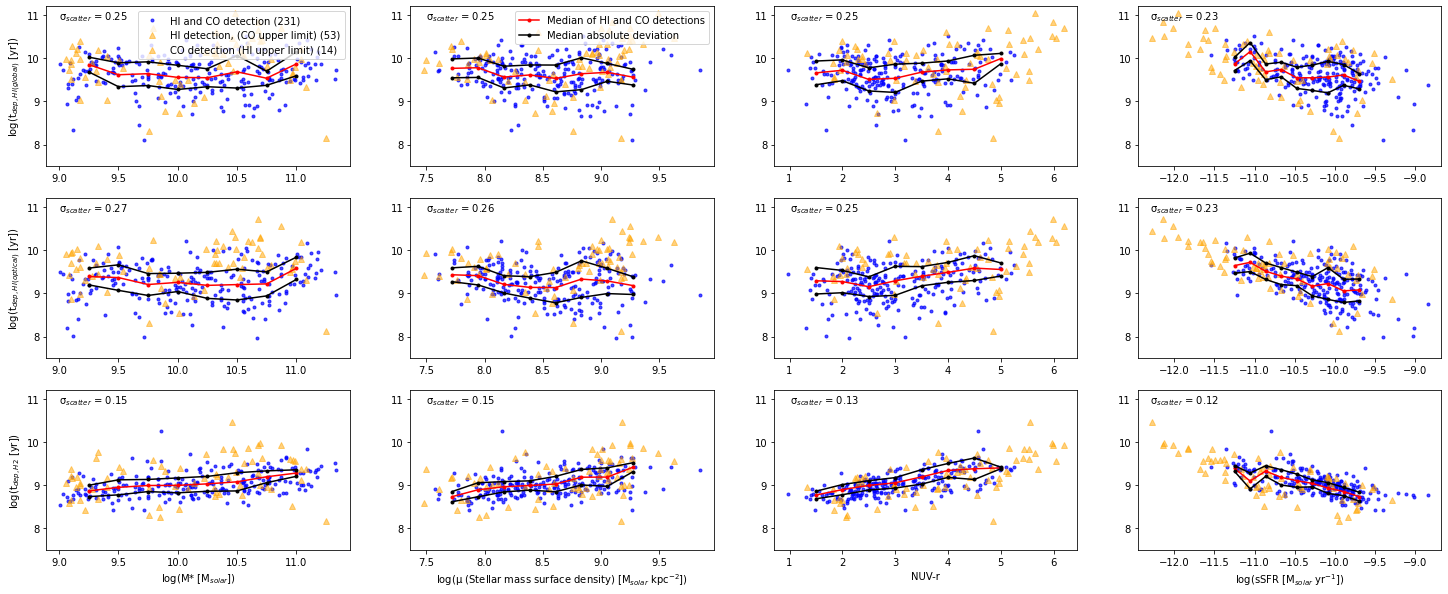

In [43]:
plt.figure(figsize=(25,10))
# Plotting the depletion time for HI(global) mass against stellar properties
# MHI(global) against stellar mass
plt.subplot(3,4,1)
plt.plot(lgMSTAR_det1, lgtdep_HIgl_det1, 'blue', alpha = 0.7, marker='.', linestyle='none', label='HI and CO detection (231)')
plt.plot(lgMSTAR_det3, lgtdep_HIgl_det3, 'orange', alpha = 0.5, marker='^', linestyle='none', label='HI detection, (CO upper limit) (53)')
plt.plot(lgMSTAR_det4, lgtdep_HIgl_det4, 'orange', alpha = 0.5, marker='^', linestyle='none', label='CO detection (HI upper limit) (14)')
plt.ylabel('log(t$_{dep, HI (global)}$ [yr])')
plt.ylim(7.5, 11.2)
plt.plot(bins_Mstar[1:-1], tdep_HIglmedian_Mstar[1:-1], 'red', marker= '.')
plt.plot(bins_Mstar[1:-1], tdep_HIglpMAD_Mstar[1:-1], 'black', marker= '.')
plt.plot(bins_Mstar[1:-1], tdep_HIglnMAD_Mstar[1:-1], 'black', marker= '.')
plt.text(9, 10.9, 'σ$_{scatter}$ = %.2f' % ScatHIgl_Mstar)
plt.legend(loc='upper right')
# Depletion time of MHI(global) against stellar surface density
plt.subplot(3,4,2)
plt.plot(lgMuST_det1, lgtdep_HIgl_det1, 'blue', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(lgMuST_det3, lgtdep_HIgl_det3, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMuST_det4, lgtdep_HIgl_det4, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.ylim(7.5, 11.2)
plt.plot(bins_Must[1:-1], tdep_HIglmedian_Must[1:-1], 'red', marker= '.', label='Median of HI and CO detections')
plt.plot(bins_Must[1:-1], tdep_HIglpMAD_Must[1:-1], 'black', marker= '.', label='Median absolute deviation')
plt.plot(bins_Must[1:-1], tdep_HIglnMAD_Must[1:-1], 'black', marker= '.')
plt.text(7.5, 10.9, 'σ$_{scatter}$ = %.2f' % ScatHIgl_Must)
plt.legend(loc='upper right')
# Depletion time of MHI(global) against NUV-r
plt.subplot(3,4,3)
plt.plot(NUVr_det1, lgtdep_HIgl_det1,'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(NUVr_det3, lgtdep_HIgl_det3, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(NUVr_det4, lgtdep_HIgl_det4, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.ylim(7.5, 11.2)
plt.plot(bins_NUVr[1:-1], tdep_HIglmedian_NUVr[1:-1], 'red', marker= '.')
plt.plot(bins_NUVr[1:-1], tdep_HIglpMAD_NUVr[1:-1], 'black', marker= '.')
plt.plot(bins_NUVr[1:-1], tdep_HIglnMAD_NUVr[1:-1], 'black', marker= '.')
plt.text(1, 10.9, 'σ$_{scatter}$ = %.2f' % ScatHIgl_NUVr)
# Depletion time of MHI(global) against sSFR
plt.subplot(3,4,4)
plt.plot(lgsSFR_det1, lgtdep_HIgl_det1, 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgsSFR_det3, lgtdep_HIgl_det3, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgsSFR_det4, lgtdep_HIgl_det4, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.ylim(7.5, 11.2)
plt.plot(bins_sSFR[:-1], tdep_HIglmedian_sSFR[:-1], 'red', marker= '.')
plt.plot(bins_sSFR[:-1], tdep_HIglpMAD_sSFR[:-1], 'black', marker= '.')
plt.plot(bins_sSFR[:-1], tdep_HIglnMAD_sSFR[:-1], 'black', marker= '.')
plt.text(-12.3, 10.9, 'σ$_{scatter}$ = %.2f' % ScatHIgl_sSFR)

# Plotting the depletion time for HI(in) mass against stellar properties
# Depletion time of MHI(in) against stellar mass
plt.subplot(3,4,5)
plt.plot(lgMSTAR_det1, lgtdep_HIin_det1, 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgMSTAR_det3, lgtdep_HIin_det3, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMSTAR_det4, lgtdep_HIin_det4, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.ylabel('log(t$_{dep, HI(optical)}$ [yr])')
plt.ylim(7.5, 11.2)
plt.plot(bins_Mstar[1:-1], tdep_HIinmedian_Mstar[1:-1], 'red', marker= '.')
plt.plot(bins_Mstar[1:-1], tdep_HIinpMAD_Mstar[1:-1], 'black', marker= '.')
plt.plot(bins_Mstar[1:-1], tdep_HIinnMAD_Mstar[1:-1], 'black', marker= '.')
plt.text(9, 10.9, 'σ$_{scatter}$ = %.2f' % ScatHIin_Mstar)
# Depletion time of MHI(in) against stellar surface density
plt.subplot(3,4,6)
plt.plot(lgMuST_det1, lgtdep_HIin_det1, 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgMuST_det3, lgtdep_HIin_det3, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMuST_det4, lgtdep_HIin_det4, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.ylim(7.5, 11.2)
plt.plot(bins_Must[1:-1], tdep_HIinmedian_Must[1:-1], 'red', marker= '.')
plt.plot(bins_Must[1:-1], tdep_HIinpMAD_Must[1:-1], 'black', marker= '.')
plt.plot(bins_Must[1:-1], tdep_HIinnMAD_Must[1:-1], 'black', marker= '.')
plt.text(7.5, 10.9, 'σ$_{scatter}$ = %.2f' % ScatHIin_Must)
# Depletion time of MHI(in) against NUV-r
plt.subplot(3,4,7)
plt.plot(NUVr_det1, lgtdep_HIin_det1, 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(NUVr_det3, lgtdep_HIin_det3, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(NUVr_det4, lgtdep_HIin_det4, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.ylim(7.5, 11.2)
plt.plot(bins_NUVr[1:-1], tdep_HIinmedian_NUVr[1:-1], 'red', marker= '.')
plt.plot(bins_NUVr[1:-1], tdep_HIinpMAD_NUVr[1:-1], 'black', marker= '.')
plt.plot(bins_NUVr[1:-1], tdep_HIinnMAD_NUVr[1:-1], 'black', marker= '.')
plt.text(1, 10.9, 'σ$_{scatter}$ = %.2f' % ScatHIin_NUVr)
# Depletion time of MHI(in) against sSFR
plt.subplot(3,4,8)
plt.plot(lgsSFR_det1, lgtdep_HIin_det1, 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgsSFR_det3, lgtdep_HIin_det3, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgsSFR_det4, lgtdep_HIin_det4, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.ylim(7.5, 11.2)
plt.plot(bins_sSFR[:-1], tdep_HIinmedian_sSFR[:-1], 'red', marker= '.')
plt.plot(bins_sSFR[:-1], tdep_HIinpMAD_sSFR[:-1], 'black', marker= '.')
plt.plot(bins_sSFR[:-1], tdep_HIinnMAD_sSFR[:-1], 'black', marker= '.')
plt.text(-12.3, 10.9, 'σ$_{scatter}$ = %.2f' % ScatHIin_sSFR)

# Plotting the depletion time of H2 mass against stellar properties
# Depletion time of MH2 against stellar mass
plt.subplot(3,4,9)
plt.plot(lgMSTAR_det1, lgtdep_H2_det1, 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgMSTAR_det3, lgtdep_H2_det3, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMSTAR_det4, lgtdep_H2_det4, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.ylabel('log(t$_{dep, H2}$ [yr])')
plt.xlabel('log(M* [M$_{solar}$])')
plt.ylim(7.5, 11.2)
plt.plot(bins_Mstar[1:-1], tdep_H2median_Mstar[1:-1], 'red', marker= '.')
plt.plot(bins_Mstar[1:-1], tdep_H2pMAD_Mstar[1:-1], 'black', marker= '.')
plt.plot(bins_Mstar[1:-1], tdep_H2nMAD_Mstar[1:-1], 'black', marker= '.')
plt.text(9, 10.9, 'σ$_{scatter}$ = %.2f' % ScatH2_Mstar)
# Depletion time of MH2 against stellar surface density
plt.subplot(3,4,10)
plt.plot(lgMuST_det1, lgtdep_H2_det1, 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgMuST_det3, lgtdep_H2_det3, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMuST_det4, lgtdep_H2_det4, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.xlabel('log(μ (Stellar mass surface density) [M$_{solar}$ kpc$^{-2}$])')
plt.ylim(7.5, 11.2)
plt.plot(bins_Must[1:-1], tdep_H2median_Must[1:-1], 'red', marker= '.')
plt.plot(bins_Must[1:-1], tdep_H2pMAD_Must[1:-1], 'black', marker= '.')
plt.plot(bins_Must[1:-1], tdep_H2nMAD_Must[1:-1], 'black', marker= '.')
plt.text(7.5, 10.9, 'σ$_{scatter}$ = %.2f' % ScatH2_Must)
# Depletion time of MH2 against NUVr
plt.subplot(3,4,11)
plt.plot(NUVr_det1, lgtdep_H2_det1, 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(NUVr_det3, lgtdep_H2_det3, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(NUVr_det4, lgtdep_H2_det4, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.xlabel('NUV-r')
plt.ylim(7.5, 11.2)
plt.plot(bins_NUVr[1:-1], tdep_H2median_NUVr[1:-1], 'red', marker= '.')
plt.plot(bins_NUVr[1:-1], tdep_H2pMAD_NUVr[1:-1], 'black', marker= '.')
plt.plot(bins_NUVr[1:-1], tdep_H2nMAD_NUVr[1:-1], 'black', marker= '.')
plt.text(1, 10.9, 'σ$_{scatter}$ = %.2f' % ScatH2_NUVr)
# Depletion time of MH2 against sSFR
plt.subplot(3,4,12)
plt.plot(lgsSFR_det1, lgtdep_H2_det1, 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgsSFR_det3, lgtdep_H2_det3, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgsSFR_det4, lgtdep_H2_det4, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.xlabel('log(sSFR [M$_{solar}$ yr$^{-1}$])')
plt.ylim(7.5, 11.2)
plt.plot(bins_sSFR[:-1], tdep_H2median_sSFR[:-1], 'red', marker= '.')
plt.plot(bins_sSFR[:-1], tdep_H2pMAD_sSFR[:-1], 'black', marker= '.')
plt.plot(bins_sSFR[:-1], tdep_H2nMAD_sSFR[:-1], 'black', marker= '.')
plt.text(-12.3, 10.9, 'σ$_{scatter}$ = %.2f' % ScatH2_sSFR);

In [44]:
print(len(np.where(lgtdep_HIgl_det1 > 10)[0]))
print(len(np.where(lgtdep_HIin_det1 > 10)[0]))
print(len(np.where(lgtdep_H2_det1 > 10)[0]))

40
5
1


In [45]:
print(len(np.where(lgtdep_HIgl_det1 > 9)[0]))
print(len(np.where(lgtdep_HIin_det1 > 9)[0]))
print(len(np.where(lgtdep_H2_det1 > 9)[0]))

213
169
117


In [46]:
print(len(np.where(lgtdep_HIgl_det1 > 8.5)[0]))
print(len(np.where(lgtdep_HIin_det1 > 8.5)[0]))
print(len(np.where(lgtdep_H2_det1 > 8.5)[0]))

228
221
228


In [47]:
print(np.mean(lgtdep_HIgl_det1 - lgtdep_HIin_det1))

0.37695897794674366


7) Changing the depletion time plots to incude how the bulge-to-total ratio changes

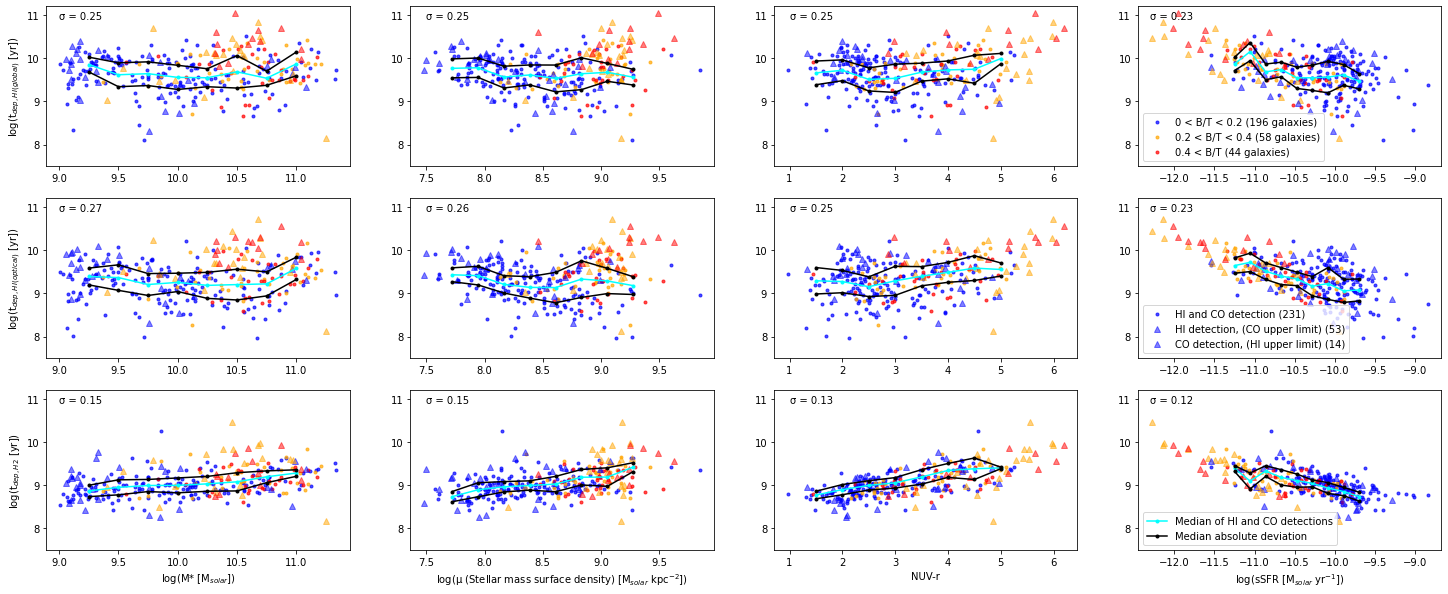

In [48]:
plt.figure(figsize=(25,10))
# Plotting the depletion time for HI(global) mass against stellar properties
# MHI(global) against stellar mass
plt.subplot(3,4,1)
plt.plot(lgMSTAR_det1[np.where(B2TM_det1 < 0.2)], lgtdep_HIgl_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker='.', linestyle='none')
plt.plot(lgMSTAR_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_HIgl_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker='.', linestyle='none')
plt.plot(lgMSTAR_det1[np.where(B2TM_det1 > 0.4)], lgtdep_HIgl_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker='.', linestyle='none')

plt.plot(lgMSTAR_det3[np.where(B2TM_det3 < 0.2)], lgtdep_HIgl_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker='^', linestyle='none')
plt.plot(lgMSTAR_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_HIgl_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker='^', linestyle='none')
plt.plot(lgMSTAR_det3[np.where(B2TM_det3 > 0.4)], lgtdep_HIgl_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker='^', linestyle='none')

plt.plot(lgMSTAR_det4[np.where(B2TM_det4 < 0.2)], lgtdep_HIgl_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker='^', linestyle='none')
plt.plot(lgMSTAR_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_HIgl_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker='^', linestyle='none')
plt.plot(lgMSTAR_det4[np.where(B2TM_det4 > 0.4)], lgtdep_HIgl_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker='^', linestyle='none')

plt.ylabel('log(t$_{dep, HI (global)}$ [yr])')
plt.ylim(7.5, 11.2)

plt.plot(bins_Mstar[1:-1], tdep_HIglmedian_Mstar[1:-1], 'cyan', marker= '.')
plt.plot(bins_Mstar[1:-1], tdep_HIglpMAD_Mstar[1:-1], 'black', marker= '.')
plt.plot(bins_Mstar[1:-1], tdep_HIglnMAD_Mstar[1:-1], 'black', marker= '.')
plt.text(9, 10.9, 'σ = %.2f' % ScatHIgl_Mstar)

# Depletion time of MHI(global) against stellar surface density
plt.subplot(3,4,2)
plt.plot(lgMuST_det1[np.where(B2TM_det1 < 0.2)], lgtdep_HIgl_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(lgMuST_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_HIgl_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(lgMuST_det1[np.where(B2TM_det1 > 0.4)], lgtdep_HIgl_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none')

plt.plot(lgMuST_det3[np.where(B2TM_det3 < 0.2)], lgtdep_HIgl_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMuST_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_HIgl_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMuST_det3[np.where(B2TM_det3 > 0.4)], lgtdep_HIgl_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker= '^', linestyle='none')

plt.plot(lgMuST_det4[np.where(B2TM_det4 < 0.2)], lgtdep_HIgl_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMuST_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_HIgl_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMuST_det4[np.where(B2TM_det4 > 0.4)], lgtdep_HIgl_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker= '^', linestyle='none')

plt.ylim(7.5, 11.2)

plt.plot(bins_Must[1:-1], tdep_HIglmedian_Must[1:-1], 'cyan', marker= '.')
plt.plot(bins_Must[1:-1], tdep_HIglpMAD_Must[1:-1], 'black', marker= '.')
plt.plot(bins_Must[1:-1], tdep_HIglnMAD_Must[1:-1], 'black', marker= '.')
plt.text(7.5, 10.9, 'σ = %.2f' % ScatHIgl_Must)


# Depletion time of MHI(global) against NUV-r
plt.subplot(3,4,3)
plt.plot(NUVr_det1[np.where(B2TM_det1 < 0.2)], lgtdep_HIgl_det1[np.where(B2TM_det1 < 0.2)],'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(NUVr_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_HIgl_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(NUVr_det1[np.where(B2TM_det1 > 0.4)], lgtdep_HIgl_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none')

plt.plot(NUVr_det3[np.where(B2TM_det3 < 0.2)], lgtdep_HIgl_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(NUVr_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_HIgl_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(NUVr_det3[np.where(B2TM_det3 > 0.4)], lgtdep_HIgl_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker= '^', linestyle='none')

plt.plot(NUVr_det4[np.where(B2TM_det4 < 0.2)], lgtdep_HIgl_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(NUVr_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_HIgl_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(NUVr_det4[np.where(B2TM_det4 > 0.4)], lgtdep_HIgl_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker= '^', linestyle='none')

plt.ylim(7.5, 11.2)

plt.plot(bins_NUVr[1:-1], tdep_HIglmedian_NUVr[1:-1], 'cyan', marker= '.')
plt.plot(bins_NUVr[1:-1], tdep_HIglpMAD_NUVr[1:-1], 'black', marker= '.')
plt.plot(bins_NUVr[1:-1], tdep_HIglnMAD_NUVr[1:-1], 'black', marker= '.')
plt.text(1, 10.9, 'σ = %.2f' % ScatHIgl_NUVr)


# Depletion time of MHI(global) against sSFR
plt.subplot(3,4,4)
plt.plot(lgsSFR_det1[np.where(B2TM_det1 < 0.2)], lgtdep_HIgl_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker= '.', linestyle='none', label= '0 < B/T < 0.2 (196 galaxies)')
plt.plot(lgsSFR_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_HIgl_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none', label= '0.2 < B/T < 0.4 (58 galaxies)')
plt.plot(lgsSFR_det1[np.where(B2TM_det1 > 0.4)], lgtdep_HIgl_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none', label= '0.4 < B/T (44 galaxies)')

plt.plot(lgsSFR_det3[np.where(B2TM_det3 < 0.2)], lgtdep_HIgl_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgsSFR_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_HIgl_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgsSFR_det3[np.where(B2TM_det3 > 0.4)], lgtdep_HIgl_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker= '^', linestyle='none')

plt.plot(lgsSFR_det4[np.where(B2TM_det4 < 0.2)], lgtdep_HIgl_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgsSFR_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_HIgl_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgsSFR_det4[np.where(B2TM_det4 > 0.4)], lgtdep_HIgl_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker= '^', linestyle='none')

plt.ylim(7.5, 11.2)

plt.plot(bins_sSFR[:-1], tdep_HIglmedian_sSFR[:-1], 'cyan', marker= '.')
plt.plot(bins_sSFR[:-1], tdep_HIglpMAD_sSFR[:-1], 'black', marker= '.')
plt.plot(bins_sSFR[:-1], tdep_HIglnMAD_sSFR[:-1], 'black', marker= '.')
plt.text(-12.3, 10.9, 'σ = %.2f' % ScatHIgl_sSFR)
plt.legend(loc='lower left')

# Plotting the depletion time for HI(in) mass against stellar properties
# Depletion time of MHI(in) against stellar mass
plt.subplot(3,4,5)
plt.plot(lgMSTAR_det1[np.where(B2TM_det1 < 0.2)], lgtdep_HIin_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgMSTAR_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_HIin_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(lgMSTAR_det1[np.where(B2TM_det1 > 0.4)], lgtdep_HIin_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none')

plt.plot(lgMSTAR_det3[np.where(B2TM_det3 < 0.2)], lgtdep_HIin_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMSTAR_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_HIin_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker = '^', linestyle='none')
plt.plot(lgMSTAR_det3[np.where(B2TM_det3 > 0.4)], lgtdep_HIin_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker = '^', linestyle='none')

plt.plot(lgMSTAR_det4[np.where(B2TM_det4 < 0.2)], lgtdep_HIin_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMSTAR_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_HIin_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker = '^', linestyle='none')
plt.plot(lgMSTAR_det4[np.where(B2TM_det4 > 0.4)], lgtdep_HIin_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker = '^', linestyle='none')

plt.ylabel('log(t$_{dep, HI(optical)}$ [yr])')
plt.ylim(7.5, 11.2)

plt.plot(bins_Mstar[1:-1], tdep_HIinmedian_Mstar[1:-1], 'cyan', marker= '.')
plt.plot(bins_Mstar[1:-1], tdep_HIinpMAD_Mstar[1:-1], 'black', marker= '.')
plt.plot(bins_Mstar[1:-1], tdep_HIinnMAD_Mstar[1:-1], 'black', marker= '.')
plt.text(9, 10.9, 'σ = %.2f' % ScatHIin_Mstar)

# Depletion time of MHI(in) against stellar surface density
plt.subplot(3,4,6)
plt.plot(lgMuST_det1[np.where(B2TM_det1 < 0.2)], lgtdep_HIin_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgMuST_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_HIin_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(lgMuST_det1[np.where(B2TM_det1 > 0.4)], lgtdep_HIin_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none')

plt.plot(lgMuST_det3[np.where(B2TM_det3 < 0.2)], lgtdep_HIin_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMuST_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_HIin_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker = '^', linestyle='none')
plt.plot(lgMuST_det3[np.where(B2TM_det3 > 0.4)], lgtdep_HIin_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker = '^', linestyle='none')

plt.plot(lgMuST_det4[np.where(B2TM_det4 < 0.2)], lgtdep_HIin_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMuST_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_HIin_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker = '^', linestyle='none')
plt.plot(lgMuST_det4[np.where(B2TM_det4 > 0.4)], lgtdep_HIin_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker = '^', linestyle='none')

plt.ylim(7.5, 11.2)

plt.plot(bins_Must[1:-1], tdep_HIinmedian_Must[1:-1], 'cyan', marker= '.')
plt.plot(bins_Must[1:-1], tdep_HIinpMAD_Must[1:-1], 'black', marker= '.')
plt.plot(bins_Must[1:-1], tdep_HIinnMAD_Must[1:-1], 'black', marker= '.')
plt.text(7.5, 10.9, 'σ = %.2f' % ScatHIin_Must)

# Depletion time of MHI(in) against NUV-r
plt.subplot(3,4,7)
plt.plot(NUVr_det1[np.where(B2TM_det1 < 0.2)], lgtdep_HIin_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(NUVr_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_HIin_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(NUVr_det1[np.where(B2TM_det1 > 0.4)], lgtdep_HIin_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none')

plt.plot(NUVr_det3[np.where(B2TM_det3 < 0.2)], lgtdep_HIin_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(NUVr_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_HIin_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker = '^', linestyle='none')
plt.plot(NUVr_det3[np.where(B2TM_det3 > 0.4)], lgtdep_HIin_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker = '^', linestyle='none')

plt.plot(NUVr_det4[np.where(B2TM_det4 < 0.2)], lgtdep_HIin_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(NUVr_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_HIin_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker = '^', linestyle='none')
plt.plot(NUVr_det4[np.where(B2TM_det4 > 0.4)], lgtdep_HIin_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker = '^', linestyle='none')

plt.ylim(7.5, 11.2)

plt.plot(bins_NUVr[1:-1], tdep_HIinmedian_NUVr[1:-1], 'cyan', marker= '.')
plt.plot(bins_NUVr[1:-1], tdep_HIinpMAD_NUVr[1:-1], 'black', marker= '.')
plt.plot(bins_NUVr[1:-1], tdep_HIinnMAD_NUVr[1:-1], 'black', marker= '.')
plt.text(1, 10.9, 'σ = %.2f' % ScatHIin_NUVr)

# Depletion time of MHI(in) against sSFR
plt.subplot(3,4,8)
plt.plot(lgsSFR_det1[np.where(B2TM_det1 < 0.2)], lgtdep_HIin_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker= '.', linestyle='none', label='HI and CO detection (231)')
plt.plot(lgsSFR_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_HIin_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(lgsSFR_det1[np.where(B2TM_det1 > 0.4)], lgtdep_HIin_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none')

plt.plot(lgsSFR_det3[np.where(B2TM_det3 < 0.2)], lgtdep_HIin_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none', label='HI detection, (CO upper limit) (53)')
plt.plot(lgsSFR_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_HIin_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker = '^', linestyle='none')
plt.plot(lgsSFR_det3[np.where(B2TM_det3 > 0.4)], lgtdep_HIin_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker = '^', linestyle='none')

plt.plot(lgsSFR_det4[np.where(B2TM_det4 < 0.2)], lgtdep_HIin_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none', label='CO detection, (HI upper limit) (14)')
plt.plot(lgsSFR_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_HIin_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker = '^', linestyle='none')
plt.plot(lgsSFR_det4[np.where(B2TM_det4 > 0.4)], lgtdep_HIin_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker = '^', linestyle='none')

plt.ylim(7.5, 11.2)

plt.plot(bins_sSFR[:-1], tdep_HIinmedian_sSFR[:-1], 'cyan', marker= '.')
plt.plot(bins_sSFR[:-1], tdep_HIinpMAD_sSFR[:-1], 'black', marker= '.')
plt.plot(bins_sSFR[:-1], tdep_HIinnMAD_sSFR[:-1], 'black', marker= '.')
plt.text(-12.3, 10.9, 'σ = %.2f' % ScatHIin_sSFR)
plt.legend(loc='lower left')

# Plotting the depletion time of H2 mass against stellar properties
# Depletion time of MH2 against stellar mass
plt.subplot(3,4,9)
plt.plot(lgMSTAR_det1[np.where(B2TM_det1 < 0.2)], lgtdep_H2_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgMSTAR_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_H2_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(lgMSTAR_det1[np.where(B2TM_det1 > 0.4)], lgtdep_H2_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none')

plt.plot(lgMSTAR_det3[np.where(B2TM_det3 < 0.2)], lgtdep_H2_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMSTAR_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_H2_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker = '^', linestyle='none')
plt.plot(lgMSTAR_det3[np.where(B2TM_det3 > 0.4)], lgtdep_H2_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker = '^', linestyle='none')

plt.plot(lgMSTAR_det4[np.where(B2TM_det4 < 0.2)], lgtdep_H2_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMSTAR_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_H2_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker = '^', linestyle='none')
plt.plot(lgMSTAR_det4[np.where(B2TM_det4 > 0.4)], lgtdep_H2_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker = '^', linestyle='none')

plt.ylabel('log(t$_{dep, H2}$ [yr])')
plt.xlabel('log(M* [M$_{solar}$])')
plt.ylim(7.5, 11.2)

plt.plot(bins_Mstar[1:-1], tdep_H2median_Mstar[1:-1], 'cyan', marker= '.')
plt.plot(bins_Mstar[1:-1], tdep_H2pMAD_Mstar[1:-1], 'black', marker= '.')
plt.plot(bins_Mstar[1:-1], tdep_H2nMAD_Mstar[1:-1], 'black', marker= '.')
plt.text(9, 10.9, 'σ = %.2f' % ScatH2_Mstar)

# Depletion time of MH2 against stellar surface density
plt.subplot(3,4,10)
plt.plot(lgMuST_det1[np.where(B2TM_det1 < 0.2)], lgtdep_H2_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgMuST_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_H2_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(lgMuST_det1[np.where(B2TM_det1 > 0.4)], lgtdep_H2_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none')

plt.plot(lgMuST_det3[np.where(B2TM_det3 < 0.2)], lgtdep_H2_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMuST_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_H2_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker = '^', linestyle='none')
plt.plot(lgMuST_det3[np.where(B2TM_det3 > 0.4)], lgtdep_H2_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker = '^', linestyle='none')

plt.plot(lgMuST_det4[np.where(B2TM_det4 < 0.2)], lgtdep_H2_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMuST_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_H2_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker = '^', linestyle='none')
plt.plot(lgMuST_det4[np.where(B2TM_det4 > 0.4)], lgtdep_H2_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker = '^', linestyle='none')

plt.xlabel('log(μ (Stellar mass surface density) [M$_{solar}$ kpc$^{-2}$])')
plt.ylim(7.5, 11.2)

plt.plot(bins_Must[1:-1], tdep_H2median_Must[1:-1], 'cyan', marker= '.')
plt.plot(bins_Must[1:-1], tdep_H2pMAD_Must[1:-1], 'black', marker= '.')
plt.plot(bins_Must[1:-1], tdep_H2nMAD_Must[1:-1], 'black', marker= '.')
plt.text(7.5, 10.9, 'σ = %.2f' % ScatH2_Must)

# Depletion time of MH2 against NUVr
plt.subplot(3,4,11)
plt.plot(NUVr_det1[np.where(B2TM_det1 < 0.2)], lgtdep_H2_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(NUVr_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_H2_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(NUVr_det1[np.where(B2TM_det1 > 0.4)], lgtdep_H2_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none')

plt.plot(NUVr_det3[np.where(B2TM_det3 < 0.2)], lgtdep_H2_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(NUVr_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_H2_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker = '^', linestyle='none')
plt.plot(NUVr_det3[np.where(B2TM_det3 > 0.4)], lgtdep_H2_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker = '^', linestyle='none')

plt.plot(NUVr_det4[np.where(B2TM_det4 < 0.2)], lgtdep_H2_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(NUVr_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_H2_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker = '^', linestyle='none')
plt.plot(NUVr_det4[np.where(B2TM_det4 > 0.4)], lgtdep_H2_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker = '^', linestyle='none')

plt.xlabel('NUV-r')
plt.ylim(7.5, 11.2)

plt.plot(bins_NUVr[1:-1], tdep_H2median_NUVr[1:-1], 'cyan', marker= '.')
plt.plot(bins_NUVr[1:-1], tdep_H2pMAD_NUVr[1:-1], 'black', marker= '.')
plt.plot(bins_NUVr[1:-1], tdep_H2nMAD_NUVr[1:-1], 'black', marker= '.')
plt.text(1, 10.9, 'σ = %.2f' % ScatH2_NUVr)

# Depletion time of MH2 against sSFR
plt.subplot(3,4,12)
plt.plot(lgsSFR_det1[np.where(B2TM_det1 < 0.2)], lgtdep_H2_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgsSFR_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_H2_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(lgsSFR_det1[np.where(B2TM_det1 > 0.4)], lgtdep_H2_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none')

plt.plot(lgsSFR_det3[np.where(B2TM_det3 < 0.2)], lgtdep_H2_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgsSFR_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_H2_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker = '^', linestyle='none')
plt.plot(lgsSFR_det3[np.where(B2TM_det3 > 0.4)], lgtdep_H2_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker = '^', linestyle='none')

plt.plot(lgsSFR_det4[np.where(B2TM_det4 < 0.2)], lgtdep_H2_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgsSFR_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_H2_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker = '^', linestyle='none')
plt.plot(lgsSFR_det4[np.where(B2TM_det4 > 0.4)], lgtdep_H2_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker = '^', linestyle='none')

plt.xlabel('log(sSFR [M$_{solar}$ yr$^{-1}$])')
plt.ylim(7.5, 11.2)

plt.plot(bins_sSFR[:-1], tdep_H2median_sSFR[:-1], 'cyan', marker= '.', label='Median of HI and CO detections')
plt.plot(bins_sSFR[:-1], tdep_H2pMAD_sSFR[:-1], 'black', marker= '.', label='Median absolute deviation')
plt.plot(bins_sSFR[:-1], tdep_H2nMAD_sSFR[:-1], 'black', marker= '.')
plt.text(-12.3, 10.9, 'σ = %.2f' % ScatH2_sSFR)
plt.legend(loc='lower left');


8) Removing the points on the above graph and adding a shaded confidence region. Comparing the difference in medians of the total HI + CO detections between the sample of points that are disk dominated and the entire sample.

In [49]:
# Finding the MAD and median lines for the total galaxies is the 231 galaxies listed in the previous plot
# Finding the MAD and median lines for the disk-dominated galaxies only
# Stellar parameters
lgMSTAR_det1_d = lgMSTAR_det1[np.where(B2TM_det1 < 0.2)]
lgMSTAR_det3_d = lgMSTAR_det3[np.where(B2TM_det3 < 0.2)]
lgMSTAR_det4_d = lgMSTAR_det4[np.where(B2TM_det4 < 0.2)]

lgMuST_det1_d = lgMuST_det1[np.where(B2TM_det1 < 0.2)]
lgMuST_det3_d = lgMuST_det3[np.where(B2TM_det3 < 0.2)]
lgMuST_det4_d = lgMuST_det4[np.where(B2TM_det4 < 0.2)]

NUVr_det1_d = NUVr_det1[np.where(B2TM_det1 < 0.2)]
NUVr_det3_d = NUVr_det3[np.where(B2TM_det3 < 0.2)]
NUVr_det4_d = NUVr_det4[np.where(B2TM_det4 < 0.2)]

lgsSFR_det1_d = lgsSFR_det1[np.where(B2TM_det1 < 0.2)]
lgsSFR_det3_d = lgsSFR_det3[np.where(B2TM_det3 < 0.2)]
lgsSFR_det4_d = lgsSFR_det4[np.where(B2TM_det4 < 0.2)]

# Selecting the galaxies (detections only) that are disk dominated
# HI (global)
lgtdep_HIgl_det_d = lgtdep_HIgl_det1[np.where(B2TM_det1 < 0.2)]
# HI (inner)
lgtdep_HIin_det_d = lgtdep_HIin_det1[np.where(B2TM_det1 < 0.2)]
# H2
lgtdep_H2_det_d = lgtdep_H2_det1[np.where(B2TM_det1 < 0.2)]

In [50]:
# Arrays for the bins
bins_Mstar_d = np.linspace(9, 11.25, 10)
bins_NUVr_d = np.linspace(1, 5.5, 10)
bins_sSFR_d = np.linspace(-11.25, -9.5, 10)
bins_Must_d = np.linspace(7.5, 9.5, 10)

# Array of zeroes to store the median of each bin
# Depletion times for HI (global)
tdep_HIglmedian_Mstar_d = np.zeros(len(bins_Mstar_d))
tdep_HIglMAD_Mstar_d = np.zeros(len(bins_Mstar_d))

tdep_HIglmedian_NUVr_d = np.zeros(len(bins_NUVr_d))
tdep_HIglMAD_NUVr_d = np.zeros(len(bins_NUVr_d))

tdep_HIglmedian_sSFR_d = np.zeros(len(bins_sSFR_d))
tdep_HIglMAD_sSFR_d = np.zeros(len(bins_sSFR_d))

tdep_HIglmedian_Must_d = np.zeros(len(bins_Must_d))
tdep_HIglMAD_Must_d = np.zeros(len(bins_Must_d))

# Depletion times for HI (optical)
tdep_HIinmedian_Mstar_d = np.zeros(len(bins_Mstar_d))
tdep_HIinMAD_Mstar_d = np.zeros(len(bins_Mstar_d))

tdep_HIinmedian_NUVr_d = np.zeros(len(bins_NUVr_d))
tdep_HIinMAD_NUVr_d = np.zeros(len(bins_NUVr_d))

tdep_HIinmedian_sSFR_d = np.zeros(len(bins_sSFR_d))
tdep_HIinMAD_sSFR_d = np.zeros(len(bins_sSFR_d))

tdep_HIinmedian_Must_d = np.zeros(len(bins_Must_d))
tdep_HIinMAD_Must_d = np.zeros(len(bins_Must_d))

# Depletion time for H2
tdep_H2median_Mstar_d = np.zeros(len(bins_Mstar_d))
tdep_H2MAD_Mstar_d = np.zeros(len(bins_Mstar_d))

tdep_H2median_NUVr_d = np.zeros(len(bins_NUVr_d))
tdep_H2MAD_NUVr_d = np.zeros(len(bins_NUVr_d))

tdep_H2median_sSFR_d = np.zeros(len(bins_sSFR_d))
tdep_H2MAD_sSFR_d = np.zeros(len(bins_sSFR_d))

tdep_H2median_Must_d = np.zeros(len(bins_Must_d))
tdep_H2MAD_Must_d = np.zeros(len(bins_Must_d))

In [51]:
# Using a for loop to iterate over the median values for each of the bins
for i in range(len(bins_Mstar_d) -1):
  # Depletion time of HI (global) (disk dominated, detections)
  # Median and MAD for the Mstar graph
  tdep_HIglmedian_Mstar_d[i] = np.median(lgtdep_HIgl_det_d[np.where((lgMSTAR_det1_d >= bins_Mstar_d[i]) & (lgMSTAR_det1_d <= bins_Mstar_d[i+1]))])
  tdep_HIglMAD_Mstar_d[i] = stats.median_abs_deviation(lgtdep_HIgl_det_d[np.where((lgMSTAR_det1_d >= bins_Mstar_d[i]) & (lgMSTAR_det1_d <= bins_Mstar_d[i+1]))])

  # Median and MAD for the NUV-r graph
  tdep_HIglmedian_NUVr_d[i] = np.median(lgtdep_HIgl_det_d[np.where((NUVr_det1_d >= bins_NUVr_d[i]) & (NUVr_det1_d <= bins_NUVr_d[i+1]))])
  tdep_HIglMAD_NUVr_d[i] = stats.median_abs_deviation(lgtdep_HIgl_det_d[np.where((NUVr_det1_d >= bins_NUVr_d[i]) & (NUVr_det1_d <= bins_NUVr_d[i+1]))])

  # Median and MAD for the sSFR graph
  tdep_HIglmedian_sSFR_d[i] = np.median(lgtdep_HIgl_det_d[np.where((lgsSFR_det1_d >= bins_sSFR_d[i]) & (lgsSFR_det1_d <= bins_sSFR_d[i+1]))])
  tdep_HIglMAD_sSFR_d[i] = stats.median_abs_deviation(lgtdep_HIgl_det_d[np.where((lgsSFR_det1_d >= bins_sSFR_d[i]) & (lgsSFR_det1_d <= bins_sSFR_d[i+1]))])

  # Median and MAD for the Must graph
  tdep_HIglmedian_Must_d[i] = np.median(lgtdep_HIgl_det_d[np.where((lgMuST_det1_d >= bins_Must_d[i]) & (lgMuST_det1_d <= bins_Must_d[i+1]))])
  tdep_HIglMAD_Must_d[i] = stats.median_abs_deviation(lgtdep_HIgl_det_d[np.where((lgMuST_det1_d >= bins_Must_d[i]) & (lgMuST_det1_d <= bins_Must_d[i+1]))])

  # Depletion time of HI (optical) (disk dominated, detections)
  # Median and MAD for the Mstar graph
  tdep_HIinmedian_Mstar_d[i] = np.median(lgtdep_HIin_det_d[np.where((lgMSTAR_det1_d >= bins_Mstar_d[i]) & (lgMSTAR_det1_d <= bins_Mstar_d[i+1]))])
  tdep_HIinMAD_Mstar_d[i] = stats.median_abs_deviation(lgtdep_HIin_det_d[np.where((lgMSTAR_det1_d >= bins_Mstar_d[i]) & (lgMSTAR_det1_d <= bins_Mstar_d[i+1]))])

  # Median and MAD for the NUV-r graph
  tdep_HIinmedian_NUVr_d[i] = np.median(lgtdep_HIin_det_d[np.where((NUVr_det1_d >= bins_NUVr_d[i]) & (NUVr_det1_d <= bins_NUVr_d[i+1]))])
  tdep_HIinMAD_NUVr_d[i] = stats.median_abs_deviation(lgtdep_HIin_det_d[np.where((NUVr_det1_d >= bins_NUVr_d[i]) & (NUVr_det1_d <= bins_NUVr_d[i+1]))])

  # Median and MAD for the sSFR graph
  tdep_HIinmedian_sSFR_d[i] = np.median(lgtdep_HIin_det_d[np.where((lgsSFR_det1_d >= bins_sSFR_d[i]) & (lgsSFR_det1_d <= bins_sSFR_d[i+1]))])
  tdep_HIinMAD_sSFR_d[i] = stats.median_abs_deviation(lgtdep_HIin_det_d[np.where((lgsSFR_det1_d >= bins_sSFR_d[i]) & (lgsSFR_det1_d <= bins_sSFR_d[i+1]))])
  
  #Median and MAD for the Must graph
  tdep_HIinmedian_Must_d[i] = np.median(lgtdep_HIin_det_d[np.where((lgMuST_det1_d >= bins_Must_d[i]) & (lgMuST_det1_d <= bins_Must_d[i+1]))])
  tdep_HIinMAD_Must_d[i] = stats.median_abs_deviation(lgtdep_HIin_det_d[np.where((lgMuST_det1_d >= bins_Must_d[i]) & (lgMuST_det1_d <= bins_Must_d[i+1]))])
  
  # Depletion time of H2 (disk dominated, detections)
  # Median and MAD for the Mstar graph
  tdep_H2median_Mstar_d[i] = np.median(lgtdep_H2_det_d[np.where((lgMSTAR_det1_d >= bins_Mstar_d[i]) & (lgMSTAR_det1_d <= bins_Mstar_d[i+1]))])
  tdep_H2MAD_Mstar_d[i] = stats.median_abs_deviation(lgtdep_H2_det_d[np.where((lgMSTAR_det1_d >= bins_Mstar_d[i]) & (lgMSTAR_det1_d <= bins_Mstar_d[i+1]))])

  # Median and MAD for the NUV-r graph
  tdep_H2median_NUVr_d[i] = np.median(lgtdep_H2_det_d[np.where((NUVr_det1_d >= bins_NUVr_d[i]) & (NUVr_det1_d <= bins_NUVr_d[i+1]))])
  tdep_H2MAD_NUVr_d[i] = stats.median_abs_deviation(lgtdep_H2_det_d[np.where((NUVr_det1_d >= bins_NUVr_d[i]) & (NUVr_det1_d <= bins_NUVr_d[i+1]))])

  # Median and MAD for the sSFR graph
  tdep_H2median_sSFR_d[i] = np.median(lgtdep_H2_det_d[np.where((lgsSFR_det1_d >= bins_sSFR_d[i]) & (lgsSFR_det1_d <= bins_sSFR_d[i+1]))])
  tdep_H2MAD_sSFR_d[i] = stats.median_abs_deviation(lgtdep_H2_det_d[np.where((lgsSFR_det1_d >= bins_sSFR_d[i]) & (lgsSFR_det1_d <= bins_sSFR_d[i+1]))])
  
  #Median and MAD for the Must graph
  tdep_H2median_Must_d[i] = np.median(lgtdep_H2_det_d[np.where((lgMuST_det1_d >= bins_Must_d[i]) & (lgMuST_det1_d <= bins_Must_d[i+1]))])
  tdep_H2MAD_Must_d[i] = stats.median_abs_deviation(lgtdep_H2_det_d[np.where((lgMuST_det1_d >= bins_Must_d[i]) & (lgMuST_det1_d <= bins_Must_d[i+1]))])

In [52]:
# Working out the upper and lower bounds of the median absolute deviation
# HI (global)
# Mstar graph median bounds
tdep_HIglpMAD_Mstar_d = tdep_HIglmedian_Mstar_d + tdep_HIglMAD_Mstar_d
tdep_HIglnMAD_Mstar_d = tdep_HIglmedian_Mstar_d - tdep_HIglMAD_Mstar_d
# NUV-r graph median bounds
tdep_HIglpMAD_NUVr_d = tdep_HIglmedian_NUVr_d + tdep_HIglMAD_NUVr_d
tdep_HIglnMAD_NUVr_d = tdep_HIglmedian_NUVr_d - tdep_HIglMAD_NUVr_d
# sSFR graph median bounds
tdep_HIglpMAD_sSFR_d = tdep_HIglmedian_sSFR_d + tdep_HIglMAD_sSFR_d
tdep_HIglnMAD_sSFR_d = tdep_HIglmedian_sSFR_d - tdep_HIglMAD_sSFR_d
# Must graph median bounds
tdep_HIglpMAD_Must_d = tdep_HIglmedian_Must_d + tdep_HIglMAD_Must_d
tdep_HIglnMAD_Must_d = tdep_HIglmedian_Must_d - tdep_HIglMAD_Must_d

# HI (optical)
# Mstar graph median bounds
tdep_HIinpMAD_Mstar_d = tdep_HIinmedian_Mstar_d + tdep_HIinMAD_Mstar_d
tdep_HIinnMAD_Mstar_d = tdep_HIinmedian_Mstar_d - tdep_HIinMAD_Mstar_d
# NUV-r graph median bounds
tdep_HIinpMAD_NUVr_d = tdep_HIinmedian_NUVr_d + tdep_HIinMAD_NUVr_d
tdep_HIinnMAD_NUVr_d = tdep_HIinmedian_NUVr_d - tdep_HIinMAD_NUVr_d
# sSFR graph median bounds
tdep_HIinpMAD_sSFR_d = tdep_HIinmedian_sSFR_d + tdep_HIinMAD_sSFR_d
tdep_HIinnMAD_sSFR_d = tdep_HIinmedian_sSFR_d - tdep_HIinMAD_sSFR_d
# Must graph median bounds
tdep_HIinpMAD_Must_d = tdep_HIinmedian_Must_d + tdep_HIinMAD_Must_d
tdep_HIinnMAD_Must_d = tdep_HIinmedian_Must_d - tdep_HIinMAD_Must_d

# H2
# Mstar graph median bounds
tdep_H2pMAD_Mstar_d = tdep_H2median_Mstar_d + tdep_H2MAD_Mstar_d
tdep_H2nMAD_Mstar_d = tdep_H2median_Mstar_d - tdep_H2MAD_Mstar_d
# NUV-r graph median bounds
tdep_H2pMAD_NUVr_d = tdep_H2median_NUVr_d + tdep_H2MAD_NUVr_d
tdep_H2nMAD_NUVr_d = tdep_H2median_NUVr_d - tdep_H2MAD_NUVr_d
# sSFR graph median bounds
tdep_H2pMAD_sSFR_d = tdep_H2median_sSFR_d + tdep_H2MAD_sSFR_d
tdep_H2nMAD_sSFR_d = tdep_H2median_sSFR_d - tdep_H2MAD_sSFR_d
# Must graph median bounds
tdep_H2pMAD_Must_d = tdep_H2median_Must_d + tdep_H2MAD_Must_d
tdep_H2nMAD_Must_d = tdep_H2median_Must_d - tdep_H2MAD_Must_d

In [53]:
# Finding the scatter present between the median lines and MAD for each plot
# Depletion time of HI (global)
ScatHIgl_Mstar_d = np.mean(tdep_HIglMAD_Mstar_d[1:-1])
ScatHIgl_NUVr_d = np.mean(tdep_HIglMAD_NUVr_d[1:-1])
ScatHIgl_sSFR_d = np.mean(tdep_HIglMAD_sSFR_d[:-1])
ScatHIgl_Must_d = np.mean(tdep_HIglMAD_Must_d[1:-1])
# Depletion time of HI (optical)
ScatHIin_Mstar_d = np.mean(tdep_HIinMAD_Mstar_d[1:-1])
ScatHIin_NUVr_d = np.mean(tdep_HIinMAD_NUVr_d[1:-1])
ScatHIin_sSFR_d = np.mean(tdep_HIinMAD_sSFR_d[:-1])
ScatHIin_Must_d = np.mean(tdep_HIinMAD_Must_d[1:-1])
# Depletion time of H2
ScatH2_Mstar_d = np.mean(tdep_H2MAD_Mstar_d[1:-1])
ScatH2_NUVr_d = np.mean(tdep_H2MAD_NUVr_d[1:-1])
ScatH2_sSFR_d = np.mean(tdep_H2MAD_sSFR_d[:-1])
ScatH2_Must_d = np.mean(tdep_H2MAD_Must_d[1:-1])

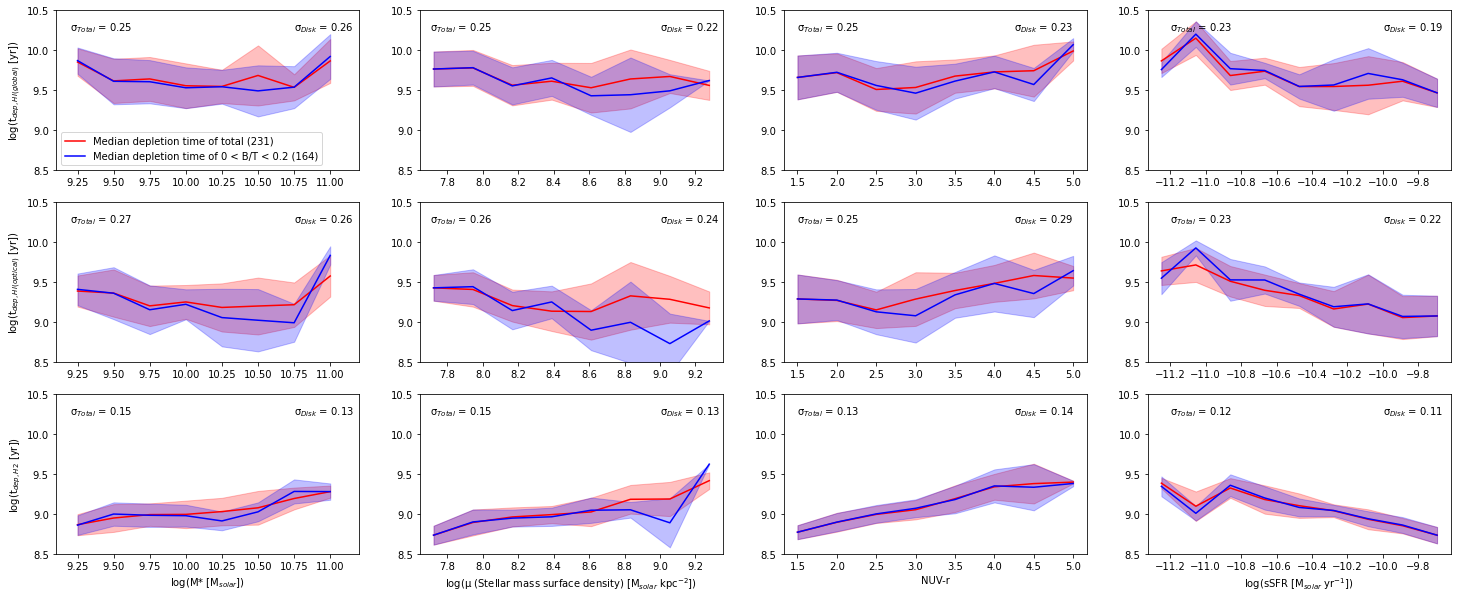

In [54]:
# Plotting the median lines for disk dominated vs the whole sample across four stellar properties
plt.figure(figsize=(25,10))
# Plotting the depletion time for HI(global) mass against stellar properties
# MHI(global) against stellar mass
plt.subplot(3,4,1)
plt.ylim(8.5, 10.5)
plt.xlim(9.1, 11.2)
plt.plot(bins_Mstar[1:-1], tdep_HIglmedian_Mstar[1:-1], 'red', label='Median depletion time of total (231)')
plt.fill_between(bins_Mstar[1:-1], tdep_HIglnMAD_Mstar[1:-1], tdep_HIglpMAD_Mstar[1:-1], color= 'r', alpha = 0.25)
plt.plot(bins_Mstar_d[1:-1], tdep_HIglmedian_Mstar_d[1:-1], 'blue', label='Median depletion time of 0 < B/T < 0.2 (164)')
plt.fill_between(bins_Mstar_d[1:-1], tdep_HIglnMAD_Mstar_d[1:-1], tdep_HIglpMAD_Mstar_d[1:-1], color= 'b', alpha = 0.25)
plt.ylabel('log(t$_{dep, HI (global)}$ [yr])')
plt.text(9.2, 10.25, 'σ$_{Total}$ = %.2f' % ScatHIgl_Mstar)
plt.text(10.75, 10.25, 'σ$_{Disk}$ = %.2f' % ScatHIgl_Mstar_d)
plt.legend(loc='lower left')

# Depletion time of MHI(global) against stellar surface density
plt.subplot(3,4,2)
plt.ylim(8.5, 10.5)
plt.plot(bins_Must[1:-1], tdep_HIglmedian_Must[1:-1], 'red')
plt.fill_between(bins_Must[1:-1], tdep_HIglnMAD_Must[1:-1], tdep_HIglpMAD_Must[1:-1], color= 'r', alpha = 0.25)
plt.plot(bins_Must_d[1:-1], tdep_HIglmedian_Must_d[1:-1], 'blue')
plt.fill_between(bins_Must_d[1:-1], tdep_HIglnMAD_Must_d[1:-1], tdep_HIglpMAD_Must_d[1:-1], color= 'b', alpha = 0.25)
plt.text(7.7, 10.25, 'σ$_{Total}$ = %.2f' % ScatHIgl_Must)
plt.text(9, 10.25, 'σ$_{Disk}$ = %.2f' % ScatHIgl_Must_d)

# Depletion time of MHI(global) against NUV-r
plt.subplot(3,4,3)
plt.ylim(8.5, 10.5)
plt.plot(bins_NUVr[1:-1], tdep_HIglmedian_NUVr[1:-1], 'red')
plt.fill_between(bins_NUVr[1:-1], tdep_HIglnMAD_NUVr[1:-1], tdep_HIglpMAD_NUVr[1:-1], color= 'r', alpha = 0.25)
plt.plot(bins_NUVr_d[1:-1], tdep_HIglmedian_NUVr_d[1:-1], 'blue')
plt.fill_between(bins_NUVr_d[1:-1], tdep_HIglnMAD_NUVr_d[1:-1], tdep_HIglpMAD_NUVr_d[1:-1], color= 'b', alpha = 0.25)
plt.text(1.5, 10.25, 'σ$_{Total}$ = %.2f' % ScatHIgl_NUVr)
plt.text(4.25, 10.25, 'σ$_{Disk}$ = %.2f' % ScatHIgl_NUVr_d)

# Depletion time of MHI(global) against sSFR
plt.subplot(3,4,4)
plt.ylim(8.5, 10.5)
plt.plot(bins_sSFR[:-1], tdep_HIglmedian_sSFR[:-1], 'red')
plt.fill_between(bins_sSFR[:-1], tdep_HIglnMAD_sSFR[:-1], tdep_HIglpMAD_sSFR[:-1], color= 'r', alpha = 0.25)
plt.plot(bins_sSFR_d[:-1], tdep_HIglmedian_sSFR_d[:-1], 'blue')
plt.fill_between(bins_sSFR_d[:-1], tdep_HIglnMAD_sSFR_d[:-1], tdep_HIglpMAD_sSFR_d[:-1], color= 'b', alpha = 0.25)
plt.text(-11.2, 10.25, 'σ$_{Total}$ = %.2f' % ScatHIgl_sSFR)
plt.text(-10, 10.25, 'σ$_{Disk}$ = %.2f' % ScatHIgl_sSFR_d)


# Plotting the depletion time for HI(in) mass against stellar properties
# Depletion time of MHI(in) against stellar mass
plt.subplot(3,4,5)
plt.ylim(8.5, 10.5)
plt.xlim(9.1, 11.2)
plt.ylabel('log(t$_{dep, HI(optical)}$ [yr])')
plt.plot(bins_Mstar[1:-1], tdep_HIinmedian_Mstar[1:-1], 'red')
plt.fill_between(bins_Mstar[1:-1], tdep_HIinnMAD_Mstar[1:-1], tdep_HIinpMAD_Mstar[1:-1], color= 'r', alpha = 0.25)
plt.plot(bins_Mstar_d[1:-1], tdep_HIinmedian_Mstar_d[1:-1], 'blue')
plt.fill_between(bins_Mstar_d[1:-1], tdep_HIinnMAD_Mstar_d[1:-1], tdep_HIinpMAD_Mstar_d[1:-1], color= 'b', alpha = 0.25)
plt.text(9.2, 10.25, 'σ$_{Total}$ = %.2f' % ScatHIin_Mstar)
plt.text(10.75, 10.25, 'σ$_{Disk}$ = %.2f' % ScatHIin_Mstar_d)

# Depletion time of MHI(in) against stellar surface density
plt.subplot(3,4,6)
plt.ylim(8.5, 10.5)
plt.plot(bins_Must[1:-1], tdep_HIinmedian_Must[1:-1], 'red')
plt.fill_between(bins_Must[1:-1], tdep_HIinnMAD_Must[1:-1], tdep_HIinpMAD_Must[1:-1], color= 'r', alpha = 0.25)
plt.plot(bins_Must_d[1:-1], tdep_HIinmedian_Must_d[1:-1], 'blue')
plt.fill_between(bins_Must_d[1:-1], tdep_HIinnMAD_Must_d[1:-1], tdep_HIinpMAD_Must_d[1:-1], color= 'b', alpha = 0.25)
plt.text(7.7, 10.25, 'σ$_{Total}$ = %.2f' % ScatHIin_Must)
plt.text(9, 10.25, 'σ$_{Disk}$ = %.2f' % ScatHIin_Must_d)

# Depletion time of MHI(in) against NUV-r
plt.subplot(3,4,7)
plt.ylim(8.5, 10.5)
plt.plot(bins_NUVr[1:-1], tdep_HIinmedian_NUVr[1:-1], 'red')
plt.fill_between(bins_NUVr[1:-1], tdep_HIinnMAD_NUVr[1:-1], tdep_HIinpMAD_NUVr[1:-1], color= 'r', alpha = 0.25)
plt.plot(bins_NUVr_d[1:-1], tdep_HIinmedian_NUVr_d[1:-1], 'blue')
plt.fill_between(bins_NUVr_d[1:-1], tdep_HIinnMAD_NUVr_d[1:-1], tdep_HIinpMAD_NUVr_d[1:-1], color= 'b', alpha = 0.25)
plt.text(1.5, 10.25, 'σ$_{Total}$ = %.2f' % ScatHIin_NUVr)
plt.text(4.25, 10.25, 'σ$_{Disk}$ = %.2f' % ScatHIin_NUVr_d)

# Depletion time of MHI(in) against sSFR
plt.subplot(3,4,8)
plt.ylim(8.5, 10.5)
plt.plot(bins_sSFR[:-1], tdep_HIinmedian_sSFR[:-1], 'red')
plt.fill_between(bins_sSFR[:-1], tdep_HIinnMAD_sSFR[:-1], tdep_HIinpMAD_sSFR[:-1], color= 'r', alpha = 0.25)
plt.plot(bins_sSFR_d[:-1], tdep_HIinmedian_sSFR_d[:-1], 'blue')
plt.fill_between(bins_sSFR_d[:-1], tdep_HIinnMAD_sSFR_d[:-1], tdep_HIinpMAD_sSFR_d[:-1], color= 'b', alpha = 0.25)
plt.text(-11.2, 10.25, 'σ$_{Total}$ = %.2f' % ScatHIin_sSFR)
plt.text(-10, 10.25, 'σ$_{Disk}$ = %.2f' % ScatHIin_sSFR_d)


# Plotting the depletion time of H2 mass against stellar properties
# Depletion time of MH2 against stellar mass
plt.subplot(3,4,9)
plt.ylim(8.5, 10.5)
plt.xlim(9.1, 11.2)
plt.ylabel('log(t$_{dep, H2}$ [yr])')
plt.xlabel('log(M* [M$_{solar}$])')
plt.plot(bins_Mstar[1:-1], tdep_H2median_Mstar[1:-1], 'red')
plt.fill_between(bins_Mstar[1:-1], tdep_H2nMAD_Mstar[1:-1], tdep_H2pMAD_Mstar[1:-1], color= 'r', alpha = 0.25)
plt.plot(bins_Mstar_d[1:-1], tdep_H2median_Mstar_d[1:-1], 'blue')
plt.fill_between(bins_Mstar_d[1:-1], tdep_H2nMAD_Mstar_d[1:-1], tdep_H2pMAD_Mstar_d[1:-1], color= 'b', alpha = 0.25)
plt.text(9.2, 10.25, 'σ$_{Total}$ = %.2f' % ScatH2_Mstar)
plt.text(10.75, 10.25, 'σ$_{Disk}$ = %.2f' % ScatH2_Mstar_d)

# Depletion time of MH2 against stellar surface density
plt.subplot(3,4,10)
plt.ylim(8.5, 10.5)
plt.xlabel('log(μ (Stellar mass surface density) [M$_{solar}$ kpc$^{-2}$])')
plt.plot(bins_Must[1:-1], tdep_H2median_Must[1:-1], 'red')
plt.fill_between(bins_Must[1:-1], tdep_H2nMAD_Must[1:-1], tdep_H2pMAD_Must[1:-1], color= 'r', alpha = 0.25)
plt.plot(bins_Must_d[1:-1], tdep_H2median_Must_d[1:-1], 'blue')
plt.fill_between(bins_Must_d[1:-1], tdep_H2nMAD_Must_d[1:-1], tdep_H2pMAD_Must_d[1:-1], color= 'b', alpha = 0.25)
plt.text(7.7, 10.25, 'σ$_{Total}$ = %.2f' % ScatH2_Must)
plt.text(9, 10.25, 'σ$_{Disk}$ = %.2f' % ScatH2_Must_d)

# Depletion time of MH2 against NUVr
plt.subplot(3,4,11)
plt.ylim(8.5, 10.5)
plt.xlabel('NUV-r')
plt.plot(bins_NUVr[1:-1], tdep_H2median_NUVr[1:-1], 'red')
plt.fill_between(bins_NUVr[1:-1], tdep_H2nMAD_NUVr[1:-1], tdep_H2pMAD_NUVr[1:-1], color= 'r', alpha = 0.25)
plt.plot(bins_NUVr_d[1:-1], tdep_H2median_NUVr_d[1:-1], 'blue')
plt.fill_between(bins_NUVr_d[1:-1], tdep_H2nMAD_NUVr_d[1:-1], tdep_H2pMAD_NUVr_d[1:-1], color= 'b', alpha = 0.25)
plt.text(1.5, 10.25, 'σ$_{Total}$ = %.2f' % ScatH2_NUVr)
plt.text(4.25, 10.25, 'σ$_{Disk}$ = %.2f' % ScatH2_NUVr_d)

# Depletion time of MH2 against sSFR
plt.subplot(3,4,12)
plt.ylim(8.5, 10.5)
plt.xlabel('log(sSFR [M$_{solar}$ yr$^{-1}$])')
plt.plot(bins_sSFR[:-1], tdep_H2median_sSFR[:-1], 'red')
plt.fill_between(bins_sSFR[:-1], tdep_H2nMAD_sSFR[:-1], tdep_H2pMAD_sSFR[:-1], color= 'r', alpha = 0.25)
plt.plot(bins_sSFR_d[:-1], tdep_H2median_sSFR_d[:-1], 'blue')
plt.fill_between(bins_sSFR_d[:-1], tdep_H2nMAD_sSFR_d[:-1], tdep_H2pMAD_sSFR_d[:-1], color= 'b', alpha = 0.25)
plt.text(-11.2, 10.25, 'σ$_{Total}$ = %.2f' % ScatH2_sSFR)
plt.text(-10, 10.25, 'σ$_{Disk}$ = %.2f' % ScatH2_sSFR_d);

9) Comparing the depletion times more directly, looking at the direct correspondance of the H2 to HI (global) and the H2 to HI (optical)

In [55]:
a1 = len(lgtdep_H2_det1[np.where(B2TM_det1 < 0.2)])
b1 = len(lgtdep_H2_det3[np.where(B2TM_det3 < 0.2)])
c1 = len(lgtdep_H2_det4[np.where(B2TM_det4 < 0.2)])
d1 = a1+b1+c1
print('Disk dominated galaxies: %.1f' % d1)
a2 = len(lgtdep_H2_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))])
b2 = len(lgtdep_H2_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))])
c2 = len(lgtdep_H2_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))])
d2 = a2+b2+c2
print('Disk + bulge galaxies: %.1f' % d2)
a3 = len(lgtdep_H2_det1[np.where(B2TM_det1 > 0.4)])
b3 = len(lgtdep_H2_det3[np.where(B2TM_det3 > 0.4)])
c3 = len(lgtdep_H2_det4[np.where(B2TM_det4 > 0.4)])
d3 = a3+b3+c3
print('Prominent bulge galaxies: %.1f' % d3)

Disk dominated galaxies: 196.0
Disk + bulge galaxies: 58.0
Prominent bulge galaxies: 44.0


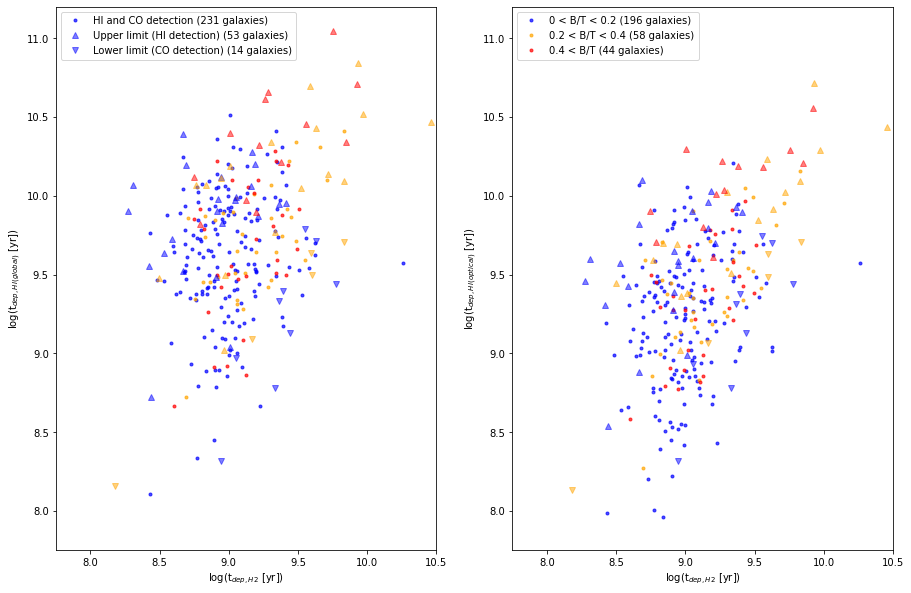

In [56]:
plt.figure(figsize=(15,10))
# Comparing H2 and HI (global)
plt.subplot(1,2,1)
plt.plot(lgtdep_H2_det1[np.where(B2TM_det1 < 0.2)], lgtdep_HIgl_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker= '.', linestyle='none', label='HI and CO detection (231 galaxies)')
plt.plot(lgtdep_H2_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_HIgl_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(lgtdep_H2_det1[np.where(B2TM_det1 > 0.4)], lgtdep_HIgl_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none')

plt.plot(lgtdep_H2_det3[np.where(B2TM_det3 < 0.2)], lgtdep_HIgl_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none', label='Upper limit (HI detection) (53 galaxies)')
plt.plot(lgtdep_H2_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_HIgl_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker = '^', linestyle='none')
plt.plot(lgtdep_H2_det3[np.where(B2TM_det3 > 0.4)], lgtdep_HIgl_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker = '^', linestyle='none')

plt.plot(lgtdep_H2_det4[np.where(B2TM_det4 < 0.2)], lgtdep_HIgl_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= 'v', linestyle='none', label='Lower limit (CO detection) (14 galaxies)')
plt.plot(lgtdep_H2_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_HIgl_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker = 'v', linestyle='none')
plt.plot(lgtdep_H2_det4[np.where(B2TM_det4 > 0.4)], lgtdep_HIgl_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker = 'v', linestyle='none')

plt.xlabel('log(t$_{dep, H2}$ [yr])')
plt.ylabel('log(t$_{dep, HI (global)}$ [yr])')
plt.xlim(7.75, 10.5)
plt.ylim(7.75, 11.2)
plt.legend(loc='upper left')

# Comparing H2 and HI (optical)
plt.subplot(1,2,2)
plt.plot(lgtdep_H2_det1[np.where(B2TM_det1 < 0.2)], lgtdep_HIin_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker= '.', linestyle='none', label= '0 < B/T < 0.2 (196 galaxies)')
plt.plot(lgtdep_H2_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_HIin_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none', label= '0.2 < B/T < 0.4 (58 galaxies)')
plt.plot(lgtdep_H2_det1[np.where(B2TM_det1 > 0.4)], lgtdep_HIin_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none', label= '0.4 < B/T (44 galaxies)')

plt.plot(lgtdep_H2_det3[np.where(B2TM_det3 < 0.2)], lgtdep_HIin_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgtdep_H2_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_HIin_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker = '^', linestyle='none')
plt.plot(lgtdep_H2_det3[np.where(B2TM_det3 > 0.4)], lgtdep_HIin_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker = '^', linestyle='none')

plt.plot(lgtdep_H2_det4[np.where(B2TM_det4 < 0.2)], lgtdep_HIin_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(lgtdep_H2_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_HIin_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker = 'v', linestyle='none')
plt.plot(lgtdep_H2_det4[np.where(B2TM_det4 > 0.4)], lgtdep_HIin_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker = 'v', linestyle='none')

plt.xlabel('log(t$_{dep, H2}$ [yr])')
plt.ylabel('log(t$_{dep, HI (optical)}$ [yr])')
plt.xlim(7.75, 10.5)
plt.ylim(7.75, 11.2)
plt.legend(loc='upper left');

10) Investigating the depletion times of the HI global, optical and H2 when compared to how offset each galaxy is from the star forming main sequence

In [57]:
# As the redshift of all the galaxies in the sample is the local universe, the best fit function used is the one from the
# Catinella and Saintonge (2021) review paper for galaxies 0.01 < z < 0.05
# lgSFR(MS) = 0.412 - log( 1+ [10^logMSTAR / 10^10.59]^-0.718 )

def SFMSfit(lgMstar):
  return 0.412 - np.log10(1+ ((10**lgMstar) / (10**10.59))**-0.718)

lgSFMS_det1 = SFMSfit(lgMSTAR_det1)
lgSFMS_det3 = SFMSfit(lgMSTAR_det3)
lgSFMS_det4 = SFMSfit(lgMSTAR_det4)

# Making an upper and lower bounds of this best fit function (+/- 0.4 dex scatter)
uplgSFMS_det1 = lgSFMS_det1 + 0.4
dwlgSFMS_det1 = lgSFMS_det1 - 0.4

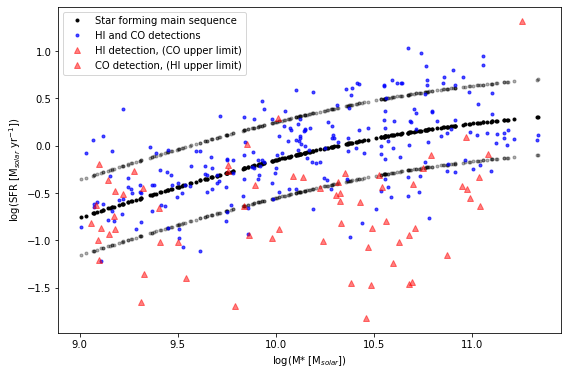

In [58]:
# Plotting the Star forming main sequence (SFMS) with the data formatted as previous
plt.figure(figsize=(9,6))
plt.plot(lgMSTAR_det1, lgSFMS_det1, 'black', marker='.', linestyle='none', label='Star forming main sequence')
plt.plot(lgMSTAR_det1, uplgSFMS_det1, 'black', marker='.', linestyle='none', alpha = 0.3)
plt.plot(lgMSTAR_det1, dwlgSFMS_det1, 'black', marker='.', linestyle='none', alpha = 0.3)
plt.plot(lgMSTAR_det1, lgSFRbest_det1, 'blue', alpha = 0.7, marker= '.', linestyle='none', label='HI and CO detections')
plt.plot(lgMSTAR_det3, lgSFRbest_det3, 'red', alpha = 0.5, marker='^', linestyle='none', label='HI detection, (CO upper limit)')
plt.plot(lgMSTAR_det4, lgSFRbest_det4, 'red', alpha = 0.5, marker='^', linestyle='none', label='CO detection, (HI upper limit)')
plt.legend(loc='upper left')
plt.xlabel('log(M* [M$_{solar}$])')
plt.ylabel('log(SFR [M$_{solar}$ yr$^{-1}$])');

In [59]:
# Finding the main sequence offset: lgSFR_det(1,2,3) - lgSFMS_det(1,2,3) = lgSFMS_off_det(1,2,3)

def SFMS_off(lgSFR, lgSFMS):
  return lgSFR - lgSFMS

lgSFMS_off_det1 = SFMS_off(lgSFRbest_det1, lgSFMS_det1)
lgSFMS_off_det3 = SFMS_off(lgSFRbest_det3, lgSFMS_det3)
lgSFMS_off_det4 = SFMS_off(lgSFRbest_det4, lgSFMS_det4)
print(lgSFMS_off_det1[0:11])
print(lgSFMS_off_det3[0:11])
print(lgSFMS_off_det4[0:11])

[-0.50068384  0.6556864   0.07119545  0.02686121  0.4932023  -0.01537231
  0.2772393  -0.6099923  -0.11088517  0.05626315 -0.6526147 ]
[-0.18450218 -0.21879488 -0.16445452 -1.583161    0.09961253 -0.301803
 -0.8277867  -0.519676   -0.5243863  -0.5875528  -0.39697334]
[ 0.01695168 -1.0939667  -0.24416992 -0.71570283 -0.6889664  -0.8065466
 -0.34092876 -0.20675188 -0.78641135 -0.64825404  1.0268173 ]


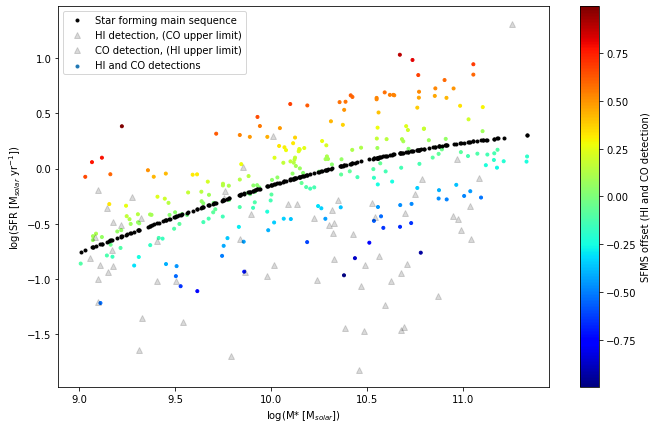

In [60]:
# Plotting a scatter plot with colourbar to reflect the offset of the data from the SFMS
plt.figure(figsize=(11,7))
plt.plot(lgMSTAR_det1, lgSFMS_det1, 'black', marker='.', linestyle='none', label='Star forming main sequence')
plt.scatter(lgMSTAR_det1, lgSFRbest_det1, c=lgSFMS_off_det1, cmap='jet', marker= '.', label='HI and CO detections')
plt.colorbar(label='SFMS offset (HI and CO detection)', orientation='vertical')
plt.plot(lgMSTAR_det3, lgSFRbest_det3, 'black', marker='^', linestyle='none', alpha=0.15, label='HI detection, (CO upper limit)')
plt.plot(lgMSTAR_det4, lgSFRbest_det4, 'black', marker='^', linestyle='none', alpha=0.15, label='CO detection, (HI upper limit)')
plt.legend(loc='upper left')
plt.xlabel('log(M* [M$_{solar}$])')
plt.ylabel('log(SFR [M$_{solar}$ yr$^{-1}$])');

In [61]:
# Using the specific star forming main sequence (sSFMS) from the xGASS paper (2018)

MSTAR_det1 = 10**lgMSTAR_det1
MSTAR_det3 = 10**lgMSTAR_det3
MSTAR_det4 = 10**lgMSTAR_det4

def sSFMSfit(Mstar):
  return -0.344*(np.log10(Mstar) -9) - 9.822

lgsSFMS_det1 = sSFMSfit(MSTAR_det1)
lgsSFMS_det3 = sSFMSfit(MSTAR_det3)
lgsSFMS_det4 = sSFMSfit(MSTAR_det4)

# Making an upper and lower bounds of this best fit function
def sigma_sSFMS(lgMstar):
  return 0.088*(lgMstar -9) + 0.188
uplgSFMS_det1 = sigma_sSFMS(MSTAR_det1)
dwlgSFMS_det1 = sigma_sSFMS(MSTAR_det1)

print(lgsSFMS_det1[0:11])
print(min(lgsSFMS_det1))

[-10.07821  -10.141662  -9.927502 -10.223448 -10.181824 -10.090662
 -10.192832 -10.230672 -10.109816  -9.897515 -10.417119]
-10.624895


In [62]:
# Finding the main sequence offset: lgSFR_det(1,2,3) - lgSFMS_det(1,2,3) = lgSFMS_off_det(1,2,3)

def sSFMS_off(lgsSFR, lgsSFMS):
  return lgsSFR - lgsSFMS

lgsSFMS_off_det1 = sSFMS_off(lgsSFR_det1, lgsSFMS_det1)
lgsSFMS_off_det3 = sSFMS_off(lgsSFR_det3, lgsSFMS_det3)
lgsSFMS_off_det4 = sSFMS_off(lgsSFR_det4, lgsSFMS_det4)
print(lgsSFMS_off_det1[0:11])
print(lgsSFMS_off_det3[0:11])
print(lgsSFMS_off_det4[0:11])

[-0.45808125  0.68006325  0.1334362   0.01639652  0.5021944   0.02419662
  0.2814455  -0.624218   -0.07648563  0.1193819  -0.80716705]
[-0.12135887 -0.21613693 -0.10428905 -1.7253952   0.16273499 -0.34908485
 -0.8705921  -0.4565916  -0.46423817 -0.62925625 -0.4880886 ]
[ 0.05882359 -1.0318289  -0.24946213 -0.6838541  -0.9350138  -0.74461365
 -0.6320925  -0.17836857 -1.0377789  -0.88339615  0.6566849 ]


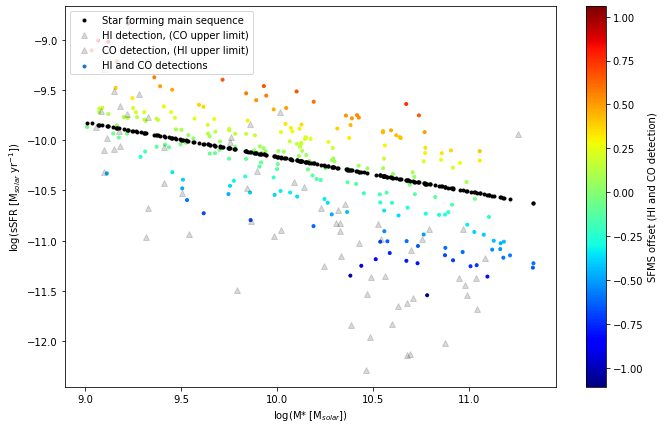

In [63]:
# Plotting a scatter plot with colourbar to reflect the offset of the data from the SFMS
plt.figure(figsize=(11,7))
plt.plot(lgMSTAR_det1, lgsSFMS_det1, 'black', marker='.', linestyle='none', label='Star forming main sequence')
plt.scatter(lgMSTAR_det1, lgsSFR_det1, c=lgsSFMS_off_det1, cmap='jet', marker= '.', label='HI and CO detections')
plt.colorbar(label='SFMS offset (HI and CO detection)', orientation='vertical')
plt.plot(lgMSTAR_det3, lgsSFR_det3, 'black', marker='^', linestyle='none', alpha=0.15, label='HI detection, (CO upper limit)')
plt.plot(lgMSTAR_det4, lgsSFR_det4, 'black', marker='^', linestyle='none', alpha=0.15, label='CO detection, (HI upper limit)')
plt.legend(loc='upper left')
plt.xlabel('log(M* [M$_{solar}$])')
plt.ylabel('log(sSFR [M$_{solar}$ yr$^{-1}$])');

11) Using the offset from the specific star forming main sequence with the depletion times to investigate the larger scatter seen by the HI when restricted to the optical region

#### Trying to find an alternative running median for the data

In [64]:
def binArray(data, axis, binstep, binsize, func=np.median):
    data = np.array(data)
    dims = np.array(data.shape)
    argdims = np.arange(data.ndim)
    argdims[0], argdims[axis]= argdims[axis], argdims[0]
    data = data.transpose(argdims)
    data = [func(np.take(data,np.arange(int(i*binstep),int(i*binstep+binsize)),0),0) for i in np.arange(dims[axis]//binstep)]
    data = np.array(data).transpose(argdims)
    return data
binned_data  = binArray(lgtdep_HIgl_det1, 0, 10, 10, np.median)
binned_x = binArray(lgsSFR_det1, 0, 10, 10, np.median)

In [65]:
data = lgtdep_HIgl_det1
bins = np.linspace(-11.5, -9.5, 20)
digitized = np.digitize(data, bins)
bin_medians = [np.median(data[digitized == i]) for i in range(1, len(bins))]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


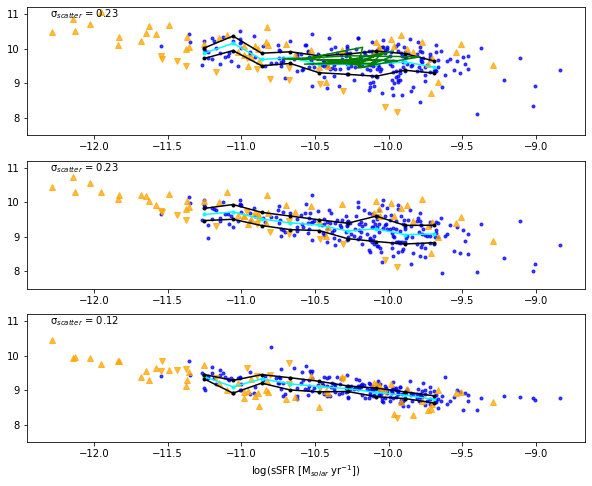

In [66]:
plt.figure(figsize=(10,8))
# Depletion time of MHI(global) against sSFR
plt.subplot(3,1,1)
plt.plot(lgsSFR_det1, lgtdep_HIgl_det1, 'blue', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgsSFR_det3, lgtdep_HIgl_det3, 'orange', alpha = 0.75, marker= '^', linestyle='none')
plt.plot(lgsSFR_det4, lgtdep_HIgl_det4, 'orange', alpha = 0.75, marker= 'v', linestyle='none')
plt.ylim(7.5, 11.2)
plt.plot(bins_sSFR[:-1], tdep_HIglmedian_sSFR[:-1], 'cyan', marker= '.')
plt.plot(bins_sSFR[:-1], tdep_HIglpMAD_sSFR[:-1], 'black', marker= '.')
plt.plot(bins_sSFR[:-1], tdep_HIglnMAD_sSFR[:-1], 'black', marker= '.')
plt.plot(binned_x, binned_data, 'g-')
plt.text(-12.3, 10.9, 'σ$_{scatter}$ = %.2f' % ScatHIgl_sSFR)

# Depletion time of MHI(in) against sSFR
plt.subplot(3,1,2)
plt.plot(lgsSFR_det1, lgtdep_HIin_det1, 'blue', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgsSFR_det3, lgtdep_HIin_det3, 'orange', alpha = 0.75, marker= '^', linestyle='none')
plt.plot(lgsSFR_det4, lgtdep_HIin_det4, 'orange', alpha = 0.75, marker= 'v', linestyle='none')
plt.ylim(7.5, 11.2)
plt.plot(bins_sSFR[:-1], tdep_HIinmedian_sSFR[:-1], 'cyan', marker= '.')
plt.plot(bins_sSFR[:-1], tdep_HIinpMAD_sSFR[:-1], 'black', marker= '.')
plt.plot(bins_sSFR[:-1], tdep_HIinnMAD_sSFR[:-1], 'black', marker= '.')
plt.text(-12.3, 10.9, 'σ$_{scatter}$ = %.2f' % ScatHIin_sSFR)

# Depletion time of MH2 against sSFR
plt.subplot(3,1,3)
plt.plot(lgsSFR_det1, lgtdep_H2_det1, 'blue', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgsSFR_det3, lgtdep_H2_det3, 'orange', alpha = 0.75, marker= '^', linestyle='none')
plt.plot(lgsSFR_det4, lgtdep_H2_det4, 'orange', alpha = 0.75, marker= 'v', linestyle='none')
plt.xlabel('log(sSFR [M$_{solar}$ yr$^{-1}$])')
plt.ylim(7.5, 11.2)
plt.plot(bins_sSFR[:-1], tdep_H2median_sSFR[:-1], 'cyan', marker= '.')
plt.plot(bins_sSFR[:-1], tdep_H2pMAD_sSFR[:-1], 'black', marker= '.')
plt.plot(bins_sSFR[:-1], tdep_H2nMAD_sSFR[:-1], 'black', marker= '.')
plt.text(-12.3, 10.9, 'σ$_{scatter}$ = %.2f' % ScatH2_sSFR);